<a href="https://colab.research.google.com/github/hoanglam372000/Applied-Data-Science-Group-7/blob/main/Notebooks/Copy_of_15_12_Report_TSE_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Báo cáo đồ án môn "Khoa học dữ liệu ứng dụng"

Nhóm 7:
1. 18120429 – Phạm Trung Kiên - trungkien2000
2. 18120431 – A Ly Ha Kim - kim-ali
3. 18120434 – Thái Hoàng Lâm - hoanglam372000
4. 18120462 – Nguyễn Thị Mận - ManCB26
Link thùng chứa Github của nhóm:
https://colab.research.google.com/github/hoanglam372000/Applied-Data-Science-Group-7

# I. Mô tả bài toán: 
## 1. Mô tả:
Link: https://www.kaggle.com/c/tweet-sentiment-extraction \

- Bài toán thuộc lĩnh vực NLP, cụ thể là bài toán phân tích cảm xúc (Sentiment Analysis)
- Không giống như những bài toán phân tích cảm xúc khác chỉ dừng ở việc phân lớp, bài toán yêu cầu phải rút trích những từ ngữ trong câu đóng góp cho cảm xúc tương ứng.
- Ví dụ: "I am happy": positive -> "happy" \

## 2. Hướng giải quyết của nhóm 
Ban đầu nhóm định theo hướng giải quyết của người đứng hạng 3 trên private leaderboard, đó là sử dụng RoBerta. Tuy nhiên, với trình độ hiện tại của các bạn trong nhóm thì phương pháp này đang vượt quá tầm với vì vậy phương hướng tiếp cận của nhóm đã vẽ ra như sau:

- Nhóm tiến hành giải bài toán theo cách riêng của nhóm: Học thống kê \
- Sau khi ra kết quả training, nếu chưa đạt được kết quả nằm trong top 20 của private leaderboard, thì nhóm sẽ tiếp tục tiếp cận dần các phương pháp Deep learning \
- Sau cùng, nếu vẫn chưa đạt được kết quả khả quan với những kiến thức deep learning đã học, nhóm sẽ tiến hành giải tiếp bài toán theo phương pháp của hạng 3 (lúc này các thành viên đã đủ kiến thức)




In [61]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# II. Giải quyết bài toán và cài đặt:

# 1. Học dựa trên thống kê

- Tiền xử lý và khám phá dữ liệu
- Xây dựng từ điển tần suất theo sentiment
- Xây dựng Bag-of-word theo xác suất Naive-Bayes
- Trích text bằng likelihood của bước trên và ước lượng ngưỡng
- Ánh xạ text đã rút trích về nguyên mẫu của từng từ trong text (đề yêu cầu)
- Đánh giá bằng độ đo Jaccard Similarity
- Tunning trên tập val để tìm siêu tham số tốt nhất
- Dự đoán rút trích trên tập test
 

### 1.1 Lấy dữ liệu, Khám phá và tiền xử lý:

#### 1.1.1 Thư viện:

In [1]:
!git clone https://github.com/hoanglam372000/Applied-Data-Science-Group-7.git

fatal: destination path 'Applied-Data-Science-Group-7' already exists and is not an empty directory.


In [2]:
!pip install emoji
!pip install pyenchant
#!pip install pycontractions

In [3]:
import math
import pandas as pd
import nltk
import numpy as np
import emoji
#import contractions
import re
import string
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import scipy.stats as st
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from keras.layers import *
from keras.models import Model
from keras.callbacks import ModelCheckpoint
#print(stopwords.words('english'))
pd.set_option('display.max_colwidth', 200)
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('names')
names = nltk.corpus.names.words('male.txt')+nltk.corpus.names.words('female.txt')
names_lower = [name.lower() for name in names]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Package names is already up-to-date!


In [4]:
!pip install afinn

In [5]:
from afinn import Afinn
afinn = Afinn(language='en')

#### 1.1.2 Khám phá dữ liệu

In [6]:
df = pd.read_csv('Applied-Data-Science-Group-7/train.csv')

In [7]:
df

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on the releases we already bought","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband lost his job and can`t afford it,d lost,negative
27477,4f4c4fc327,"I`ve wondered about rake to. The client has made it clear .NET only, don`t force devs to learn a new lang #agile #ccnet",", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - you probably need it after such hectic weekend Take care hun xxxx,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [9]:
df.dropna(inplace = True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


#### 1.1.3 Tách tập dữ liệu

In [11]:
# Tách tập huấn luyện và tập validation theo tỉ lệ 70%:30%
X_df = df.drop(labels = 'selected_text',axis = 1)
y_ex = df.selected_text
y_class = df.sentiment
train_X_df, val_X_df, train_y_ex, val_y_ex = train_test_split(X_df, y_ex, test_size=0.3, 
                                                              stratify=y_class, random_state=0)

In [12]:
print('train_X: ',train_X_df.shape)
print('train_y: ',train_y_ex.shape)
print('val_X: ',val_X_df.shape)
print('val_y: ',val_y_ex.shape)


train_X:  (19236, 3)
train_y:  (19236,)
val_X:  (8244, 3)
val_y:  (8244,)


### 1.2 Tiền xử lý + Khám phá tập train

#### 1.2.1 Khám phá tập train

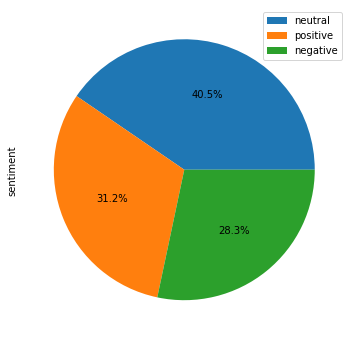

In [13]:
#Phân bố của các lớp:
train_X_df.sentiment.value_counts(normalize= True).plot(kind="pie",labels = None, legend='auto', figsize=(8,6), autopct="%.1f%%");

In [14]:
train_X_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19236 entries, 652 to 12238
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     19236 non-null  object
 1   text       19236 non-null  object
 2   sentiment  19236 non-null  object
dtypes: object(3)
memory usage: 601.1+ KB


In [15]:
train_X_df.duplicated().sum()

0

In [16]:
train_y_ex.isnull().sum()

0

#### 1.2.2 Tiền xử lý văn bản

In [17]:
 #nltk.pos_tag(['i','am','over','the','moon'])

In [18]:
# import enchant
# from nltk.metrics import edit_distance
# class SpellingReplacer(object):
#     def __init__(self, dict_name='en', max_dist=2):
#         self.spell_dict = enchant.Dict(dict_name)
#         self.max_dist = max_dist
#     def replace(self, word):
#         if self.spell_dict.check(word):
#             return word
#         suggestions = self.spell_dict.suggest(word)
#         if suggestions and edit_distance(word, suggestions[0]) <=self.max_dist:
#             return suggestions[0]
#         else:
#             return word
# replacer = SpellingReplacer()
# replacer.replace('cookbok')

In [19]:
stemmer = PorterStemmer()
# class xử lý vấn đề trùng ký tự trong từ, ví dụ yoooouuuu -> you, nooooo -> no.
#sử dụng pattern của regular expression, tuy nhiên phải quét thêm qua wordnet để tránh trường hợp như từ goose bị chuyển thành gose (mặc dù goose là từ đúng)
class RepeatReplacer(object):
    def __init__(self):
        self.repeat_regexp = re.compile(r'(\w*)(\w)\2(\w*)')
        self.repl = r'\1\2\3'
    def replace(self, word):
        if wordnet.synsets(word):
            return word
        repl_word = self.repeat_regexp.sub(self.repl, word)
        if repl_word != word:
            return self.replace(repl_word)
        else:
            return repl_word
char_repeat_correct = RepeatReplacer()
def preprocessing_word(word):
  
  if word != emoji.demojize(word):
    return emoji.demojize(word)
  #word = contractions.fix(word)
  #word = stemmer.stem(word)
  
  temp=[ "html_tag",'URL','HIDDEN','tag',"hash_tag"]
  if word in temp:
    return word
  #số theo từ
  if word.isdigit():  
    return 'NUMBER'
  try: 
    float(word)
    return 'NUMBER'
  except:
    pass


  #word=word.lower() # viết thườngthường
  #spell_corrector = Speller(lang='en') #sửa chính tả theo từng từ 
  #word=spell_corrector(word)

  # rút gọn theo từ
  #lemmatizer = WordNetLemmatizer()
  #wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
  #pos_tagged = nltk.pos_tag(word.split())
  
  #word = [lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged]
  #word = ' '.join(word)

  #word=word.translate(str.maketrans('', '', string.punctuation)) # chấm câu theo từ (vì tránh emoij)
  word = re.sub(pattern=r'["!\.#$%&\'()*+-/:;<=>@\?\[\]^_`{|}~0-9ï¿½]+', repl='', string=word)
  word = char_repeat_correct.replace(word)
  #word = stemmer.stem(word)
  #if (word in  names):
   # return '<Name>'
  #word = stemmer.stem(word)
  word = word.lower()
  
  if word==''or word ==' ':
    return "Special"
  
  # if 'not' not in word and len(word.split())!=1:
  #   return word.split()[0]+'_'
  return word.replace(' ','_')

def preprocessing_text(tweet,sentiment):
   raw_text = str(tweet).strip().replace('\n', ' ')#.lower()
   # emoij
   raw_text=emoji.demojize(raw_text)
   e_r=r':\w+_\w+:'
   emoij_list=re.findall(e_r,raw_text)
   for e in emoij_list:
     raw_text=raw_text.replace(e,' ' + emoji.emojize(e) + ' ') # "hi❤️👍"
   if sentiment !=0: 
     raw_text = re.sub(pattern=r'(?<=\w)(\.){2,}?(?=\w)', repl=' ', string=raw_text)
   new_tweet = raw_text.split()
   len_=len(new_tweet)
   index2word = { w:new_tweet[w] for w in range(len_)}
   #parser = BeautifulSoup(raw_text, "html.parser")
   #raw_text = parser.get_text(separator = "<html_tag>")
   raw_text = re.sub(pattern=r'https?://\S+|www\.\S+', repl='URL', string=raw_text)
   raw_text = re.sub(pattern='\*{3,}?', repl='HIDDEN', string=raw_text)
   raw_text = re.sub(pattern=r'@\w+', repl='tag', string=raw_text)
   raw_text = re.sub(pattern=r'#\w+', repl='hash_tag', string=raw_text)
   
   word_list=raw_text.split()
   return index2word,dict(zip([*range(len_)],map(preprocessing_word,word_list)))

In [20]:
# Test:
tweet = ' My mom just texted.......me and told *ship* James that Rodney3 charlie wasï¿½ *** chasing?? and fireflies... in their :)) backyard. Awwwww I`m miss him!!! @hoanglam 123 ://    http://twitpic.com/66pn1'
tweet2 = 'nooooooooo'
index2word_temp,preprocessed_tweet_temp = preprocessing_text(tweet2,1)
print('index2word: ',index2word_temp)
print('preprocessed_tweet: ',preprocessed_tweet_temp)

index2word:  {0: 'nooooooooo'}
preprocessed_tweet:  {0: 'no'}


In [21]:
char_repeat_correct.replace(':))))))')

':))))))'

In [22]:

def preprocess_tweets(X_df):
  X_df = X_df.copy()
  raw_tweets = X_df.text.to_list()
  X_df.sentiment = X_df.sentiment.map({'negative':-1,'neutral':0,'positive':1})
  index2word_tweets = [] #list of dictionaries
  preprocessed_tweets = [] #list of dictionaries
  cleaned_texts = []
  for tweet,senti in zip(raw_tweets,X_df.sentiment.to_list()):
    index2word, preprocessed = preprocessing_text(tweet,senti)
    index2word_tweets.append(index2word)
    preprocessed_tweets.append(preprocessed)
    cleaned_texts.append(' '.join(list(preprocessed.values())))
  preprocessed_X_df = pd.DataFrame(data={'textID':X_df.textID,'index2word':index2word_tweets, 'preprocessed_texts':preprocessed_tweets,'sentiment':X_df.sentiment})
  cleaned_int2text_df = pd.DataFrame(data={'textID':X_df.textID,'Raw_text':X_df.text, 'Cleaned_texts':cleaned_texts,'sentiment':X_df.sentiment})
  return preprocessed_X_df,cleaned_int2text_df

def _preprocessed_y_ex(X_df,y_ex):
  preprocessed_y_ex = []
  X_df = X_df.copy()
  cleaned_texts = []
  for tweet,senti in zip(y_ex.to_list(),X_df.sentiment.to_list()):
      index2word, preprocessed_y = preprocessing_text(tweet,senti)
      preprocessed_y_ex.append(preprocessed_y)
      cleaned_texts.append(' '.join(list(preprocessed_y.values())))

  X_df['sentiment'] = X_df.sentiment.map({'negative':-1,'neutral':0,'positive':1}).to_list()
  return pd.DataFrame(data = {'preprocessed_texts': preprocessed_y_ex,'Cleaned_text': cleaned_texts,'sentiment':X_df.sentiment})



In [23]:
train_X_df.head(5)

,textID,text,sentiment
652,a834cef9c6,1st presentation for senior boards? FML,negative
24883,5bfad683d5,yummy curry save me some please lol,positive
15385,08a8d660b1,I wish I knew someone down there who could hook us up. a friend told me once that they got crappy seats for a show in CHI,negative
16753,99a0ff3bef,Lucky u Im stuck in the rain...,neutral
19,40e7becabf,Hes just not that into you,neutral


In [24]:
#_preprocessed_y_ex(train_X_df.head(100),train_y_ex.head(100))

In [25]:
# Test:
preprocessed_X_df_temp,cleaned_int2text_df_temp = preprocess_tweets(train_X_df.head(100))
preprocessed_X_df_temp

,textID,index2word,preprocessed_texts,sentiment
652,a834cef9c6,"{0: '1st', 1: 'presentation', 2: 'for', 3: 'senior', 4: 'boards?', 5: 'FML'}","{0: 'st', 1: 'presentation', 2: 'for', 3: 'senior', 4: 'boards', 5: 'fml'}",-1
24883,5bfad683d5,"{0: 'yummy', 1: 'curry', 2: 'save', 3: 'me', 4: 'some', 5: 'please', 6: 'lol'}","{0: 'yummy', 1: 'curry', 2: 'save', 3: 'me', 4: 'some', 5: 'please', 6: 'lol'}",1
15385,08a8d660b1,"{0: 'I', 1: 'wish', 2: 'I', 3: 'knew', 4: 'someone', 5: 'down', 6: 'there', 7: 'who', 8: 'could', 9: 'hook', 10: 'us', 11: 'up.', 12: 'a', 13: 'friend', 14: 'told', 15: 'me', 16: 'once', 17: 'that...","{0: 'i', 1: 'wish', 2: 'i', 3: 'knew', 4: 'someone', 5: 'down', 6: 'there', 7: 'who', 8: 'could', 9: 'hook', 10: 'us', 11: 'up', 12: 'a', 13: 'friend', 14: 'told', 15: 'me', 16: 'once', 17: 'that'...",-1
16753,99a0ff3bef,"{0: 'Lucky', 1: 'u', 2: 'Im', 3: 'stuck', 4: 'in', 5: 'the', 6: 'rain...'}","{0: 'lucky', 1: 'u', 2: 'im', 3: 'stuck', 4: 'in', 5: 'the', 6: 'rain'}",0
19,40e7becabf,"{0: 'Hes', 1: 'just', 2: 'not', 3: 'that', 4: 'into', 5: 'you'}","{0: 'hes', 1: 'just', 2: 'not', 3: 'that', 4: 'into', 5: 'you'}",0
...,...,...,...,...
16799,82d211bdd5,"{0: 'i', 1: 'think', 2: 'i', 3: 'hate', 4: 'you.', 5: 'i', 6: 'didnt', 7: 'really', 8: 'want', 9: 'to', 10: 'but', 11: 'you', 12: 'make', 13: 'it', 14: 'hard', 15: 'for', 16: 'me', 17: 'to', 18: '...","{0: 'i', 1: 'think', 2: 'i', 3: 'hate', 4: 'you', 5: 'i', 6: 'didnt', 7: 'really', 8: 'want', 9: 'to', 10: 'but', 11: 'you', 12: 'make', 13: 'it', 14: 'hard', 15: 'for', 16: 'me', 17: 'to', 18: 'l...",-1
6706,7a775cc933,"{0: 'If', 1: 'I', 2: 'were', 3: 'a', 4: 'transformer...', 5: 'I`d', 6: 'step', 7: 'on', 8: 'people', 9: 'just', 10: 'to', 11: 'hear', 12: 'them', 13: '*squoosh*.', 14: 'But', 15: 'I`m', 16: 'not',...","{0: 'if', 1: 'i', 2: 'were', 3: 'a', 4: 'transformer', 5: 'id', 6: 'step', 7: 'on', 8: 'people', 9: 'just', 10: 'to', 11: 'hear', 12: 'them', 13: 'squosh', 14: 'but', 15: 'im', 16: 'not', 17: 'so'...",0
1967,127ac4d1d2,"{0: 'ohay', 1: 'clean', 2: 'teeth'}","{0: 'ohay', 1: 'clean', 2: 'teeth'}",1
9181,4b8cb4449b,"{0: 'Im', 1: 'fine', 2: 'also..up', 3: 'way', 4: 'to', 5: 'early..lol...soo', 6: 'those', 7: 'r', 8: 'all', 9: 'ur', 10: 'dogs?', 11: 'to', 12: 'kut3', 13: '..i', 14: 'def', 15: 'want', 16: 'a', 1...","{0: 'im', 1: 'fine', 2: 'alsoup', 3: 'way', 4: 'to', 5: 'earlylolso', 6: 'those', 7: 'r', 8: 'all', 9: 'ur', 10: 'dogs', 11: 'to', 12: 'kut', 13: 'i', 14: 'def', 15: 'want', 16: 'a', 17: 'pit', 18...",0


### 2. Mô hình hoá dữ liệu:

#### 2.1 Tiền xử lý:

In [26]:
preprocessed_train_X, cleaned_train_X = preprocess_tweets(train_X_df)
preprocessed_train_y_ex = _preprocessed_y_ex(train_X_df,train_y_ex)
preprocessed_val_X, cleaned_val_X = preprocess_tweets(val_X_df)
preprocessed_val_y_ex = _preprocessed_y_ex(val_X_df,val_y_ex)

In [27]:
#cleaned_train_X

In [28]:
#pd.set_option('display.max_rows', df.shape[0]+1)
visual_df = pd.DataFrame(data ={'text':preprocessed_train_X.preprocessed_texts,'selected_text':preprocessed_train_y_ex.preprocessed_texts,'sentiment':preprocessed_train_X.sentiment})
visual_df.head(10)

,text,selected_text,sentiment
652,"{0: 'st', 1: 'presentation', 2: 'for', 3: 'senior', 4: 'boards', 5: 'fml'}",{0: 'fml'},-1
24883,"{0: 'yummy', 1: 'curry', 2: 'save', 3: 'me', 4: 'some', 5: 'please', 6: 'lol'}",{0: 'yummy'},1
15385,"{0: 'i', 1: 'wish', 2: 'i', 3: 'knew', 4: 'someone', 5: 'down', 6: 'there', 7: 'who', 8: 'could', 9: 'hook', 10: 'us', 11: 'up', 12: 'a', 13: 'friend', 14: 'told', 15: 'me', 16: 'once', 17: 'that'...","{0: 'p', 1: 'a', 2: 'friend', 3: 'told', 4: 'me', 5: 'once', 6: 'that', 7: 'they', 8: 'got', 9: 'crappy', 10: 'seats', 11: 'for', 12: 'a', 13: 'show', 14: 'in'}",-1
16753,"{0: 'lucky', 1: 'u', 2: 'im', 3: 'stuck', 4: 'in', 5: 'the', 6: 'rain'}","{0: 'lucky', 1: 'u', 2: 'im', 3: 'stuck', 4: 'in', 5: 'the', 6: 'rain'}",0
19,"{0: 'hes', 1: 'just', 2: 'not', 3: 'that', 4: 'into', 5: 'you'}","{0: 'hes', 1: 'just', 2: 'not', 3: 'that', 4: 'into', 5: 'you'}",0
23126,"{0: 'gah', 1: 'Special', 2: 'this', 3: 'weather', 4: 'sucksss', 5: 'Special'}","{0: 'gah', 1: 'Special', 2: 'this', 3: 'weather', 4: 'sucksss', 5: 'Special'}",-1
27051,"{0: 'apologies', 1: 'dont', 2: 'fix', 3: 'hurt', 4: 'feelings', 5: 'kev', 6: 'anyway', 7: 'ill', 8: 'get', 9: 'it', 10: 'from', 11: 'u', 12: 'next', 13: 'time', 14: 'i', 15: 'c', 16: 'u'}","{0: 'apologies', 1: 'dont', 2: 'fix', 3: 'hurt', 4: 'feelings', 5: 'kev'}",-1
11314,"{0: 'Special', 1: 'follow', 2: 'my', 3: 'girl', 4: 'meagan'}","{0: 'Special', 1: 'follow', 2: 'my', 3: 'girl', 4: 'meagan'}",0
5854,"{0: 'this', 1: 'is', 2: 'really', 3: 'helpful', 4: 'you', 5: 'swear', 6: 'a', 7: 'lot', 8: 'i', 9: 'just', 10: 'realized', 11: 'haha'}",{0: 'helpful'},1
8160,"{0: 'happy', 1: 'mothers', 2: 'day', 3: 'x', 4: 'mum', 5: 'i', 6: 'love', 7: 'you'}",{0: 'happy'},1


In [29]:
preprocessed_train_y_ex

,preprocessed_texts,Cleaned_text,sentiment
652,{0: 'fml'},fml,-1
24883,{0: 'yummy'},yummy,1
15385,"{0: 'p', 1: 'a', 2: 'friend', 3: 'told', 4: 'me', 5: 'once', 6: 'that', 7: 'they', 8: 'got', 9: 'crappy', 10: 'seats', 11: 'for', 12: 'a', 13: 'show', 14: 'in'}",p a friend told me once that they got crappy seats for a show in,-1
16753,"{0: 'lucky', 1: 'u', 2: 'im', 3: 'stuck', 4: 'in', 5: 'the', 6: 'rain'}",lucky u im stuck in the rain,0
19,"{0: 'hes', 1: 'just', 2: 'not', 3: 'that', 4: 'into', 5: 'you'}",hes just not that into you,0
...,...,...,...
21628,{0: 'best'},best,1
24747,"{0: 'yeah', 1: 'hes', 2: 'also', 3: 'partial', 4: 'to', 5: 'jt', 6: 'and', 7: 'ti', 8: 'dead', 9: 'and', 10: 'gone', 11: 'and', 12: 'pinks', 13: 'sobre'}",yeah hes also partial to jt and ti dead and gone and pinks sobre,0
18164,"{0: 'oui', 1: 'i', 2: 'figured', 3: 'that', 4: 'since', 5: 'its', 6: 'a', 7: 'day', 8: 'off', 9: 'id', 10: 'better', 11: 'start', 12: 'brushing', 13: 'up', 14: 'on', 15: 'my', 16: 'french', 17: 's...",oui i figured that since its a day off id better start brushing up on my french so far i have learnt bonjour and oui,0
10041,"{0: 'if', 1: 'i', 2: 'can', 3: 'get', 4: 'a', 5: 'ticket', 6: 'but', 7: 'the', 8: 'pickings', 9: 'are', 10: 'lokin', 11: 'slim', 12: 'so', 13: 'prob', 14: 'not'}",if i can get a ticket but the pickings are lokin slim so prob not,0


In [30]:
# pd.set_option('display.max_rows', df.shape[0]+1)
neutral_df = visual_df.loc[visual_df.sentiment ==0,:]
#neutral_df
len_neutral_df = neutral_df.loc[:,['text','selected_text']].applymap(len)
index_neutral = len_neutral_df.loc[len_neutral_df.text == len_neutral_df.selected_text,:]
#cleaned_train_X.loc[index_neutral.index,:]
(index_neutral.shape[0]/ neutral_df.shape[0])*100
# pd.DataFrame(data ={'origin':cleaned_train_X.Raw_text,'text':cleaned_train_X.Cleaned_texts,'selected_text':preprocessed_train_y_ex.preprocessed_texts}).loc[index_neutral_diff.index,:]

88.02364430737599

In [31]:
pos_df = visual_df.loc[visual_df.sentiment ==-1
                       ,:]
len_pos_df = pos_df.loc[:,['text','selected_text']].applymap(len)
# len_pos_df.selected_text.value_counts(normalize= True)*100
len_pos_df.loc[len_pos_df.selected_text == 1,:]

,text,selected_text
652,6,1
25356,3,1
9843,3,1
11309,13,1
724,7,1
...,...,...
12530,9,1
13957,8,1
2969,16,1
24444,21,1


In [32]:
# pos_visual_df = visual_df.loc[visual_df.sentiment == 1,:]
# pos_visual_df.text.apply(len).max()

#### 2.2 Viết class và tinh chỉnh mô hình

##### 2.2.1 Sentiment Classification Class

In [29]:
class Sentiment_Classification(object):
  def __init__(self,_max_depth = 3):
        #self.num_top_titles = num_top_titles
        self._max_depth = _max_depth
  def extract_features(self,tweet, likelihood):
    '''
    Input: 
        tweet: a dictionary of words for one tweet
        likelihood: a dictionary corresponding to the score representation of each word
    Output: 
        x: a feature vector of dimension (1,3)
    '''
    word_l = list(tweet.values())
    # 3 elements in the form of a 1 x 3 vector
    x = np.zeros((1, 3))   
    # loop through each word in the list of words
    for word in word_l:
        if likelihood.get(word,0)!=0:
          # increment the word count for the positive label 1
          x[0,0] += likelihood[word][0]
        
          # increment the word count for the negative label 0
          x[0,1] += likelihood[word][1]

          x[0,2] += likelihood[word][2]
    assert(x.shape == (1, 3))
    return x
  def sentence_embeddings(self,preprocessed_X_df,likelihood):
    sentences = preprocessed_X_df.preprocessed_texts.to_list()
    X = np.zeros(shape = (len(sentences),3))
    for i in range(len(sentences)):
      X[i, :]= self.extract_features(sentences[i], likelihood)
    assert(X.shape == (len(sentences), 3))
    return X
  def _fit(self,preprocessed_y_ex,likelihood):
    # freqs_temp_train = tse_st.count_tweets(preprocessed_train_X_y)
    # vob_temp_train, likelihood_temp_train = tse_st.score_representation(freqs_temp_train,preprocessed_train_X_y)
    self._likelihood = likelihood
    train_X_TC = self.sentence_embeddings(preprocessed_y_ex,likelihood)
    train_y_TC = np.array(preprocessed_y_ex.sentiment.to_list())
    clf_RT = RandomForestClassifier(max_depth=self._max_depth, random_state=40)
    #clf = SVC(gamma='auto',probability = True,random_state=1)
    self.sentiment_tool = clf_RT.fit(train_X_TC,train_y_TC)
    self.RT_score = clf_RT.score(train_X_TC,train_y_TC)
    #self.score_train = self.sentiment_tool.score(X,y)
    return self
  def _predict(self,embeddings_X):
    # predict_word_temp = np.array(likelihood_temp['on']).reshape(1,3)
    # predict_tweet_temp = extract_features({0: 'hate'}		,likelihood_temp)
    result = self.sentiment_tool.predict(embeddings_X)
    return result

In [30]:
# preprocessed_train_X_y = pd.concat([preprocessed_train_X.loc[:,['preprocessed_texts','sentiment']],preprocessed_train_y_ex ],ignore_index= True)
# s_temp = Sentiment_Classification()
# result_temp = s_temp._fit(preprocessed_train_X_y,tse_st.likelihood)

In [31]:
# result_temp.sentiment_tool.predict(predict_tweet_temp)

##### 2.2.2 Extraction Class

In [33]:
negative_form = ['not','dont','doesnt','arent','isnt','havent','hasnt','didnt','wasnt','werent','hadnt','wont','shant','cant',\
'couldnt','neitheir','nor','rarely','hardly','seldom','never','no']
negative_form = [stemmer.stem(w) for w in negative_form]
negative_form

['not',
 'dont',
 'doesnt',
 'arent',
 'isnt',
 'havent',
 'hasnt',
 'didnt',
 'wasnt',
 'werent',
 'hadnt',
 'wont',
 'shant',
 'cant',
 'couldnt',
 'neitheir',
 'nor',
 'rare',
 'hardli',
 'seldom',
 'never',
 'no']

- Tạm thời thêm phần xử lý rút trích phủ định cho negative tweet TẠM THỜI như sau: \\ 

Xét từ phía trước nằm trong tập negative forms bên trên, nếu từ tiếp theo mang nghĩa positive thì trích nguyên cụm: negative form + positive word -> negative phrase \\

Ví dụ: not + good -> not good -> negative




In [34]:
afinn_wl_url = ('https://raw.githubusercontent.com'
                '/fnielsen/afinn/master/afinn/data/AFINN-111.txt')

afinn_wl_df = pd.read_csv(afinn_wl_url,
                          header=None, # no column names
                          sep='\t',  # tab sepeated
                          names=['term', 'value'])

In [35]:
afinn.score('internet')

0.0

In [36]:

class bayes_extraction(BaseEstimator, TransformerMixin):
    def __init__(self, k = 5,z_neg=1.65,z_neu = 1.65,z_pos=1.65,w =1, vob_threshold = 2,_max_depth = 3):
        #self.num_top_titles = num_top_titles
        self.k = k
        self.z_neg = z_neg
        self.z_neu = z_neu
        self.z_pos = z_pos
        self.vob_threshold = vob_threshold
        self.w = w
        self._max_depth = _max_depth
    def word2freqs(self,preprocessed_X):
        preprocessed_tweets = preprocessed_X.preprocessed_texts.to_list()
        list_of_tweets = [list(text.values()) for text in preprocessed_tweets ]
        vob2freq = {}
        for tw in list_of_tweets:
            for word in tw:
              if vob2freq.get(word,0) !=0:
                  vob2freq[word] +=1
              else:
                  vob2freq[word] = 1
        return vob2freq
    def count_tweets(self,preprocessed_X):
        '''
          Input:
      
            tweets: a list of tweets
            ys: a list corresponding to the sentiment of each tweet (either 0 or 1)
          Output:
              result: a dictionary mapping each pair to its frequency
        '''
        preprocessed_X = preprocessed_X.copy()
        y_s = preprocessed_X.sentiment.to_list()
        preprocessed_tweets = preprocessed_X.preprocessed_texts.to_list()
        processed_tweets = [list(text.values()) for text in preprocessed_tweets ]


        vob2freqs = self.word2freqs(preprocessed_X)
        freqs = {}

        for y, tweet in zip(y_s, processed_tweets):
            for word in tweet:
                if vob2freqs[word] < self.vob_threshold and y==0:
                    pair = ('<OOV>',y)
                else:

                    # define the key, which is the word and label tuple
                    pair = (word,y)

              # if the key exists in the dictionary, increment the count
                if pair in freqs:
                    freqs[pair] += 1

              # else, if the key is new, add it to the dictionary and set the count to 1
                else:
                    freqs[pair] = 1

        return freqs
    
    def score_representation(self,freqs,preprocessed_X):
        likelihood = {}
        preprocessed_X = preprocessed_X.copy()
        train_y = preprocessed_X.sentiment.to_list()
        preprocessed_tweets = preprocessed_X.preprocessed_texts.to_list()
        #train_x = [list(text.values()) for text in preprocessed_tweets ]
    
      
        # calculate V, the number of unique words in the vocabulary
        vocab = set([pair[0] for pair in freqs.keys()])
        vocabs_ = list(vocab)

        V = len(vocab)

        # calculate N_pos and N_neg
        N_pos = N_neg = N_neu = 0
        for pair in freqs.keys():
          # if the label is positive (greater than zero)
            if pair[1] ==1:

                # Increment the number of positive words by the count for this (word, label) pair
                  N_pos += freqs[pair]
            elif pair[1] ==0:
                  N_neu += freqs[pair]
            # else, the label is negative
            else:
                # increment the number of negative words by the count for this (word,label) pair
                  N_neg += freqs[pair]

          # Calculate D, the number of documents
        D = len(train_y)

        for word in vocab:
          # get the positive and negative frequency of the word
            freq_neg = freqs.get((word,-1),0)
            freq_neu = freqs.get((word,0),0)
            freq_pos = freqs.get((word,1),0)


          # calculate the probability that each word is positive, and negative , neutral
            s_neg = freq_neg / (freq_neg + freq_neu + freq_pos)
            s_neu = freq_neu / (freq_neg + freq_neu + freq_pos)
            s_pos = freq_pos / (freq_neg + freq_neu + freq_pos)

          # calculate the log likelihood of the word
            #likelihood[word] = [np.log(p_w_neg),np.log(p_w_neu),np.log(p_w_pos)]
            likelihood[word] = [s_neg,s_neu,s_pos]
        return vocabs_, likelihood
        
    
    def bayes_likelihood(self,freqs,preprocessed_X):
        '''
          Input:
              freqs: dictionary from (word, label) to how often the word appears
          Output:
              loglikelihood: the log likelihood of you Naive bayes equation.
        '''
        likelihood = {}
        preprocessed_X = preprocessed_X.copy()
        train_y = preprocessed_X.sentiment.to_list()
        preprocessed_tweets = preprocessed_X.preprocessed_texts.to_list()
        #train_x = [list(text.values()) for text in preprocessed_tweets ]
    

        # calculate V, the number of unique words in the vocabulary
        vocab = set([pair[0] for pair in freqs.keys()])
        vocabs_ = list(vocab)

        V = len(vocab)

        # calculate N_pos and N_neg
        N_pos = N_neg = N_neu = 0
        for pair in freqs.keys():
          # if the label is positive (greater than zero)
            if pair[1] ==1:

                # Increment the number of positive words by the count for this (word, label) pair
                  N_pos += freqs[pair]
            elif pair[1] ==0:
                  N_neu += freqs[pair]
            # else, the label is negative
            else:
                # increment the number of negative words by the count for this (word,label) pair
                  N_neg += freqs[pair]

          # Calculate D, the number of documents
        D = len(train_y)

        for word in vocab:
          # get the positive and negative frequency of the word
            freq_pos = freqs.get((word,1),0)
            freq_neu = freqs.get((word,0),0)
            freq_neg = freqs.get((word,-1),0)
        

          # calculate the probability that each word is positive, and negative , neutral
            p_w_pos = (freq_pos + self.k) / (N_pos + self.k*V)
            p_w_neu = (freq_neu + self.k) / (N_neu + self.k*V)
            p_w_neg = (freq_neg + self.k) / (N_neg + self.k*V)

          # calculate the log likelihood of the word
            #likelihood[word] = [np.log(p_w_neg),np.log(p_w_neu),np.log(p_w_pos)]
            likelihood[word] = [p_w_neg,p_w_neu,p_w_pos]
        return vocabs_, likelihood

    def lexical_sentiment_score(self,preprocessed_y_ex,x_likelihood):
        y_freqs = self.count_tweets(preprocessed_y_ex) # Dùng làm trọng số rút trích
        #vocabs_,y_likelihood = self.bayes_likelihood(y_freqs,preprocessed_y_ex)
        N_pos = N_neg = N_neu = 0
        for pair in y_freqs.keys():
          # if the label is positive (greater than zero)
            if pair[1] ==1:

                # Increment the number of positive words by the count for this (word, label) pair
                  N_pos += y_freqs[pair]
            elif pair[1] ==0:
                  N_neu += y_freqs[pair]
            # else, the label is negative
            else:
                # increment the number of negative words by the count for this (word,label) pair
                  N_neg += y_freqs[pair]

        new_x_likelihood = x_likelihood.copy()
        for w,l in x_likelihood.items():
            if y_freqs.get((w,-1),0)!=0:
                #new_x_likelihood[w][0] = np.log((1/(-new_x_likelihood[w][0]- math.pow(10,-10))) * y_freqs[(w,-1)] )
                new_x_likelihood[w][0] = new_x_likelihood[w][0]*(y_freqs[(w,-1)])*self.w
            if y_freqs.get((w,0),0)!=0:
                #new_x_likelihood[w][0] = np.log((1/(-new_x_likelihood[w][1] - math.pow(10,-10)  ))* y_freqs[(w,0)]  )
                new_x_likelihood[w][1] = new_x_likelihood[w][1]*(y_freqs[(w,0)])*self.w
            if y_freqs.get((w,1),0)!=0:
                #new_x_likelihood[w][0] = np.log((1/(-new_x_likelihood[w][2]- math.pow(10,-10))) * y_freqs[(w,1)] )
                new_x_likelihood[w][2] = new_x_likelihood[w][2]*(y_freqs[(w,1)])*self.w
        return new_x_likelihood
           
    def sentiment_word_net(self,likelihood):
          # word_net = np.zeros(shape = (len(likelihood),3))
          # list_of_score = list(likelihood.values())
          # for i in range(len(list_of_score)):
          #       word_net[i] = np.array(list_of_score[i])
          # preds_sentiment = model._predict(word_net)
          # word2sentiment = {}
          # words = list(likelihood.keys())
          # for w,p in zip(words,list(preds_sentiment)):
          #       word2sentiment[w] = p
          # return word2sentiment
          word2sentiment = {}
          for w,score in likelihood.items():
             max_prob = max(score)
             word2sentiment[w] = score.index(max_prob) -1
          return word2sentiment

    def Extract_Sentiment_Tweet(self,x_class,tweet):
          '''input:
                tweet: list of word'''
          selected_tweet = []
          s = x_class +1
          
          if s==1:
            for word in tweet:
              if self.likelihood.get(word,0) !=0:
                    neg_prob,neu_prob,pos_prob = self.likelihood[word]
                    threshold = 1+self.z_neu
                    if ((neg_prob/neu_prob) < 1 + self.z_neu) or ((pos_prob/neu_prob) < 1+ self.z_neu):
                      selected_tweet.append(word)
              else:
                  selected_tweet.append(word)
          elif s==2:
              # for word in tweet:
              #       if self.likelihood.get(word,0) !=0:
              #           # word2emb = np.array(self.likelihood[word]).reshape(1,3)
              #           # _sentiment = int(self.sentiment_tool._predict(word2emb)[0])
              #           if self.word2sentiment[word] == x_class:
              #                 selected_tweet.append(word)
            for word in tweet:
              if self.likelihood.get(word,0) !=0:
                neg_prob,neu_prob,pos_prob = self.likelihood[word]
                max_prob = max(self.likelihood[word])
                if self.likelihood[word].index(max_prob) == s:
                    if abs(max_prob -neu_prob) > self.z_pos:
                    #if max_prob/neu_prob > self.z_pos:
                        selected_tweet.append(word)
          else:
              for word_pos in range(len(tweet)):
                if self.likelihood.get(tweet[word_pos],0) !=0:
                    max_prob = max(self.likelihood[tweet[word_pos]])
                    neg_prob,neu_prob,pos_prob = self.likelihood[tweet[word_pos]]
                    if word_pos <len(tweet) -1:
                      if tweet[word_pos] in negative_form and self.word2sentiment.get(tweet[word_pos+1] ,-2)== 1:
                        selected_tweet.append(tweet[word_pos])
                        selected_tweet.append(tweet[word_pos +1])

                    if self.word2sentiment[tweet[word_pos]] == -1:
                          if abs(max_prob -neu_prob) > self.z_neg:
                    #if max_prob/neu_prob > self.z_pos:
                              selected_tweet.append(tweet[word_pos])

                
          return selected_tweet

    # def Extract_Sentiment_Tweet_Log(self,x_class,tweet):
    #     '''input:
    #       tweet: list of word'''
    #     selected_tweet = []
    #     s = x_class +1
    #     if s == 0:
    #       z = self.z_neg
    #     elif s==1:
    #       z = self.z_neu
    #     elif s ==2:
    #       z = self.z_pos
    #     sentiment_score = 0
    #     word_sentiment_score = {}
    #     word_sentiment_percent = {}
    #     for word in tweet:
    #       if self.likelihood.get(word,0)!=0:
    #             word_sentiment_score[word] = self.likelihood[word][s]
    #             sentiment_score += self.likelihood[word][s]
    #     # Tính phần trăm đóng góp sentiment của từng từ trong câu theo tỉ lệ phần trăm:
    #     for w,score in word_sentiment_score.items():
    #         percentage = (abs(score) / abs(sentiment_score))*100
    #         word_sentiment_percent[w] = percentage
    #     #print(word_sentiment_percent)
    #     #threshold = sorted(list(word_sentiment_percent.values()),reverse= True)[0]
    #     #len(list(word_sentiment_percent.values()))
    #     data = np.array(list(word_sentiment_percent.values()))
    #     if data.shape[0] !=0:
    #         threshold = data.mean() + z*(data.std()/math.sqrt(data.shape[0]))
    #     else:
    #         threshold = 0
    #     for w,percent in word_sentiment_percent.items():
    #         if percent < threshold:
    #             selected_tweet.append(w)

    #     return selected_tweet
    
    def Predict_Extract_text(self,Preprocessed_X):
        selected = []
        preprocessed_X = Preprocessed_X.copy()
        y_s = preprocessed_X.sentiment.to_list()
        preprocessed_tweets = preprocessed_X.preprocessed_texts.to_list()
        tweets = [list(text.values()) for text in preprocessed_tweets ]
        for y, tweet in zip(y_s,tweets):
            #selected_predict = Extract_Sentiment_Tweet(y,tweet,likelihood)
            selected_predict = self.Extract_Sentiment_Tweet(y,tweet)
            selected.append(selected_predict)
        return selected
    def Map_Extracted(self,Preprocessed_X,extracted_text):
        # extracted_text = self.Predict_Extract_text(Preprocessed_X)
        index2word = Preprocessed_X.index2word.to_list()
        preprocessed_texts = Preprocessed_X.preprocessed_texts.to_list()
        Selected_text = []
        for e,i,p in zip(extracted_text,index2word,preprocessed_texts):
            Text = {}
            for j in p.items():
              for w in e:
                if w == j[1]:
                  Text[j[0]] = i[j[0]]
          
            Selected_text.append(" ".join(list(Text.values())))
        
        return Selected_text

    def jaccard(self,str1, str2): 
        a = set(str1.lower().split()) 
        b = set(str2.lower().split())
        c = a.intersection(b)
        return float(len(c)) / (len(a) + len(b) - len(c))

    def fit(self, preprocessed_X_df, preprocessed_y_ex):
        #preprocessed_train_X_y = pd.concat([preprocessed_X_df.loc[:,['preprocessed_texts','sentiment']],preprocessed_y_ex ],ignore_index= True)
        self.freqs = self.count_tweets(preprocessed_X_df)
        self.vocabs, self.init_likelihood = self.bayes_likelihood(self.freqs,preprocessed_X_df)
        
        #self.vocabs, self.likelihood = self.score_representation(self.freqs,preprocessed_train_X_y)
        #self.vocabs, self.likelihood = self.bayes_likelihood(self.freqs,preprocessed_X_df)
        self.likelihood = self.lexical_sentiment_score(preprocessed_y_ex,self.init_likelihood)
        #self.sentiment_tool = Sentiment_Classification(_max_depth = self._max_depth)._fit(preprocessed_y_ex,self.likelihood)
        #self.word2sentiment = self.sentiment_word_net(self.sentiment_tool,self.likelihood)
        self.word2sentiment = self.sentiment_word_net(self.likelihood)
        return self

    def transform(self, preprocessed_X_df):
        self.extracted_text = self.Predict_Extract_text(preprocessed_X_df)
        selected_text = self.Map_Extracted(preprocessed_X_df,self.extracted_text)
        return selected_text

    def score(self,selected_text,y_ex):
        score = 0
        y_true_s = y_ex.copy().to_list()
        for y_pred, y_true in zip(selected_text,y_true_s):
            score += self.jaccard(str(y_true),y_pred)
        return score/len(y_true_s)

In [37]:
#tse_st.count_tweets(preprocessed_train_y_ex)

##### 2.2.2.1 Training

In [39]:
# Training
tse_st = bayes_extraction(z_pos= 0.00003,z_neu=4,z_neg = 0.00003,vob_threshold=1,k = 10)
selected_train_X = tse_st.fit_transform(preprocessed_train_X,preprocessed_train_y_ex)
#selected_train_X = tse_st.extract(preprocessed_train_X)
tse_st.score(selected_train_X,train_y_ex)


0.625187484136111

In [ ]:
# afinn_wl_url = ('https://raw.githubusercontent.com'
#                 '/fnielsen/afinn/master/afinn/data/AFINN-111.txt')

# afinn_wl_df = pd.read_csv(afinn_wl_url,
#                           header=None, # no column names
#                           sep='\t',  # tab sepeated
#                           names=['term', 'value'])

##### 2.2.2.2 Error Analysis

In [40]:
score_df = pd.DataFrame(data ={'selected_text':selected_val_X ,'true_text':val_y_ex, 'sentiment':val_X_df.sentiment})
check_df = score_df.loc[score_df.sentiment== 'negative',:]
check_neg = check_df.selected_text.str.split().apply(len)
# check_neg = check_neg.loc[check_neg >=7].index
# check_df = check_df.loc[check_neg,:]
# tse_st.score(check_df.selected_text.to_list(),check_df.true_text)

NameError: ignored

In [40]:
check_df.selected_text.str.split().apply(len).value_counts()


1    1070
2     533
0     492
3     166
4      49
5      15
6       8
7       1
Name: selected_text, dtype: int64

In [ ]:
pd.set_option('display.max_rows', df.shape[0]+1)
compare_df = pd.DataFrame(data ={'origin':val_X_df.text,'preprocessed_text':preprocessed_val_X.preprocessed_texts,'selected_text':selected_val_X ,'true_text':val_y_ex, 'sentiment':val_X_df.sentiment})
index_check = compare_df.loc[compare_df.sentiment == 'negative',['selected_text']].selected_text.str.split().apply(len)
index_1 = index_check.loc[index_check == 1].index
#compare_df.loc[index_1,:]

,origin,preprocessed_text,selected_text,true_text,sentiment
4402,i guess ill never have it but the sad thing is that u didn`t put an Alternate e-mail!! cause if u dont remember ur secret,"{0: 'i', 1: 'guess', 2: 'ill', 3: 'never', 4: 'have', 5: 'it', 6: 'but', 7: 'the', 8: 'sad', 9: 'thing', 10: 'is', 11: 'that', 12: 'u', 13: 'didnt', 14: 'put', 15: 'an', 16: 'alternate', 17: 'emai...",sad,t the sad thing is,negative
13240,"NAPLAN testing, tuesday, wednesday & thursday. i`m afraid about the maths one, english ,not so much","{0: 'naplan', 1: 'testing', 2: 'tuesday', 3: 'wednesday', 4: 'Special', 5: 'thursday', 6: 'im', 7: 'afraid', 8: 'about', 9: 'the', 10: 'maths', 11: 'one', 12: 'english', 13: 'not', 14: 'so', 15: '...",afraid,"i`m afraid about the maths one,",negative
12301,sucks,{0: 'sucks'},sucks,sucks,negative
24221,****. My friend`s in such a state and I don`t know how to help him. Nothing I say seems to be helping and I wish I knew what to say,"{0: 'hidden', 1: 'my', 2: 'friends', 3: 'in', 4: 'such', 5: 'a', 6: 'state', 7: 'and', 8: 'i', 9: 'dont', 10: 'know', 11: 'how', 12: 'to', 13: 'help', 14: 'him', 15: 'nothing', 16: 'i', 17: 'say',...",****.,****. My friend`s in such a state and I don`t know how to help him. Nothing I say seems to be helping and I wish I knew what to say,negative
15932,man i still haven`t seen that movie...too bad i`m at work,"{0: 'man', 1: 'i', 2: 'still', 3: 'havent', 4: 'seen', 5: 'that', 6: 'movie', 7: 'too', 8: 'bad', 9: 'im', 10: 'at', 11: 'work'}",bad,bad,negative
16288,Placed a $2 bet on a sure thing and lost. no more betting for me!,"{0: 'placed', 1: 'a', 2: 'Special', 3: 'bet', 4: 'on', 5: 'a', 6: 'sure', 7: 'thing', 8: 'and', 9: 'lost', 10: 'no', 11: 'more', 12: 'betting', 13: 'for', 14: 'me'}",lost.,Placed a $2 bet on a sure thing and lost.,negative
11988,i miss your dance friends too.,"{0: 'i', 1: 'miss', 2: 'your', 3: 'dance', 4: 'friends', 5: 'too'}",miss,i miss your dance friends too.,negative
19085,"And why do they think 'how much they want it' is a factor? I really want to be 19 and fit again, but that`s just not going to happen","{0: 'and', 1: 'why', 2: 'do', 3: 'they', 4: 'think', 5: 'how', 6: 'much', 7: 'they', 8: 'want', 9: 'it', 10: 'is', 11: 'a', 12: 'factor', 13: 'i', 14: 'really', 15: 'want', 16: 'to', 17: 'be', 18:...",fit,just not going to happen,negative
2749,ready for the weekend and sad that I have to be at the office again tomorrow morning,"{0: 'ready', 1: 'for', 2: 'the', 3: 'weekend', 4: 'and', 5: 'sad', 6: 'that', 7: 'i', 8: 'have', 9: 'to', 10: 'be', 11: 'at', 12: 'the', 13: 'office', 14: 'again', 15: 'tomorrow', 16: 'morning'}",sad,sad th,negative
141,"These kids are terrible! If I was in Good Evans, I`d call Childline","{0: 'these', 1: 'kids', 2: 'are', 3: 'terrible', 4: 'if', 5: 'i', 6: 'was', 7: 'in', 8: 'good', 9: 'evans', 10: 'id', 11: 'call', 12: 'childline'}",terrible!,terrible!,negative


In [ ]:
index_check.value_counts(dropna= False)

1    1042
2     538
0     521
3     163
4      44
5      17
6       8
7       1
Name: selected_text, dtype: int64

In [ ]:
tse_st.likelihood['like']

In [ ]:
np.array(tse_st.likelihood['like']).std()

0.12331351067287812

In [ ]:
tse_st.word2sentiment['reducul']

-1

##### 2.2.3 Draf

In [ ]:
y_freqs = tse_st.count_tweets(preprocessed_train_y_ex)
y_vobs, y_likelihood = tse_st.bayes_likelihood(y_freqs,preprocessed_train_y_ex)

In [ ]:
corpus = ['haha','The party is normal haha']#cleaned_train_X.Cleaned_texts.to_list()
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
#vectorizer.get_feature_names_out()
print(X)

  (0, 0)	1.0
  (1, 2)	0.47107781233161794
  (1, 1)	0.47107781233161794
  (1, 3)	0.47107781233161794
  (1, 4)	0.47107781233161794
  (1, 0)	0.33517574332792605


In [ ]:
a = np.array(tse_st.likelihood['haha'])
a

array([0.00168338, 0.13157643, 0.05351695])

In [ ]:
# from scipy.sparse import csr_matrix, vstack
# sparse_csr_mat = csr_matrix(X)
# sparse_csr_mat

<19236x15200 sparse matrix of type '<class 'numpy.float64'>'
	with 220401 stored elements in Compressed Sparse Row format>

In [ ]:
y_freqs[('haha',1)]

54

In [ ]:
y_likelihood['haha']

[0.00018684836632245047, 0.001125978684961638, 0.0008027292795504716]

In [ ]:
tse_st.freqs[('haha',0)]

160

In [ ]:
tse_st.likelihood['like']

[0.22009052868968537, 0.5406386760181168, 0.2876652622403022]

In [ ]:
def extract_features(tweet, likelihood):
    '''
    Input: 
        tweet: a dictionary of words for one tweet
        likelihood: a dictionary corresponding to the score representation of each word
    Output: 
        x: a feature vector of dimension (1,3)
    '''
    word_l = list(tweet.values())
    # 3 elements in the form of a 1 x 3 vector
    x = np.zeros((1, 3))   
    # loop through each word in the list of words
    for word in word_l:
        if likelihood.get(word,0)!=0:
          # increment the word count for the positive label 1
          x[0,0] += likelihood[word][0]
        
          # increment the word count for the negative label 0
          x[0,1] += likelihood[word][1]

          x[0,2] += likelihood[word][2]
    assert(x.shape == (1, 3))
    return x

In [ ]:
# Phân lớp để tìm trọng số rút trích
def sentence_embeddings(preprocessed_X_df,likelihood):
    sentences = preprocessed_X_df.preprocessed_texts.to_list()
    X = np.zeros(shape = (len(sentences),3))
    for i in range(len(sentences)):
      X[i, :]= extract_features(sentences[i], likelihood)
    assert(X.shape == (len(sentences), 3))
    return X
           
      


In [ ]:
train_X_TC  = sentence_embeddings(preprocessed_train_y_ex,tse_st.likelihood)
train_y_TC  = np.array(preprocessed_train_y_ex.sentiment.to_list())
val_X_TC = sentence_embeddings(preprocessed_val_y_ex,tse_st.likelihood)
val_y_TC = np.array(preprocessed_val_y_ex.sentiment.to_list())

NameError: ignored

In [ ]:
# from sklearn.svm import SVC
# clf = SVC(gamma='auto',probability = True,random_state=42)
# clf.fit(train_X_TC,train_y_TC)
# clf.score(train_X_TC,train_y_TC)

0.7142337284258682

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf_RT = RandomForestClassifier(max_depth=12, random_state=30)
clf_RT.fit(train_X_TC,train_y_TC)
clf_RT.score(train_X_TC,train_y_TC)


0.8509045539613225

In [ ]:
clf_RT.predict(val_X_TC)
clf_RT.score(val_X_TC,val_y_TC)

0.7680737506065017

In [ ]:
# probs_TC = clf.predict_proba(train_X_TC)


In [ ]:
predict_word_temp = np.array(tse_st.likelihood['haha']).reshape(1,3)
predict_tweet_temp = extract_features({0: 'thank', 1: 'you',2:'for'}		, tse_st.likelihood)

In [ ]:
clf_RT.predict(predict_word_temp)

AttributeError: ignored

In [ ]:
clf_RT.predict_proba(predict_word_temp)

array([[0.00448348, 0.02526129, 0.97025523]])

In [ ]:
s_temp = Sentiment_Classification()
result_temp = s_temp._fit(preprocessed_train_y_ex,tse_st.likelihood)

In [ ]:
len(tse_st.likelihood)

11343

In [ ]:
def sentiment_word_net(model,likelihood):
  word_net = np.zeros(shape = (len(likelihood),3))
  list_of_score = list(likelihood.values())
  for i in range(len(list_of_score)):
      word_net[i] = np.array(list_of_score[i])
  preds_sentiment = model.predict(word_net)
  word2sentiment = {}
  words = list(likelihood.keys())
  for w,p in zip(words,list(preds_sentiment)):
     word2sentiment[w] = p
  return word2sentiment

In [ ]:
model_temp = sentiment_word_net(clf_RT,tse_st.likelihood)

In [ ]:
tse_st.likelihood['love']

[0.002778920816788957, 0.17323752556041813, 2.8097797887133935]

In [ ]:
model_temp['you']

1

In [ ]:
# freqs_temp = tse_st.count_tweets(preprocessed_train_y_ex)
# vob_temp, likelihood_temp = tse_st.score_representation(freqs_temp,preprocessed_train_y_ex)
# X_temp = sentence_embeddings(preprocessed_train_y_ex,likelihood_temp)
# clf_temp = SVC(gamma='auto',probability = True,random_state=1)
# clf_temp.fit(X_temp,train_y_TC)
# clf_temp.score(X_temp,train_y_TC)

0.8739342898731545

In [ ]:
# preprocessed_train_X.tail(5)

,textID,index2word,preprocessed_texts,sentiment
21628,148582dfe6,"{0: 'THE', 1: 'best', 2: 'job', 3: 'in', 4: 'the', 5: 'world', 6: '&', 7: 'yes', 8: 'its', 9: 'in', 10: 'Australia', 11: 'http://tinyurl.com/clxl4l'}","{0: 'the', 1: 'best', 2: 'job', 3: 'in', 4: 'the', 5: 'world', 6: '<Special_Character>', 7: 'ye', 8: 'it', 9: 'in', 10: 'australia', 11: '<URL>'}",1
24747,9ed3b39ceb,"{0: 'Yeah', 1: 'he`s', 2: 'also', 3: 'partial', 4: 'to', 5: 'JT', 6: 'and', 7: 'TI', 8: 'Dead', 9: 'and', 10: 'Gone', 11: 'and', 12: 'Pink`s', 13: 'Sobre'}","{0: 'yeah', 1: 'he', 2: 'also', 3: 'partial', 4: 'to', 5: 'jt', 6: 'and', 7: 'ti', 8: 'dead', 9: 'and', 10: 'gone', 11: 'and', 12: 'pink', 13: 'sobr'}",0
18164,b2ccc6e924,"{0: 'Oui,', 1: 'I', 2: 'figured', 3: 'that', 4: 'since', 5: 'its', 6: 'a', 7: 'day', 8: 'off,', 9: 'I`d', 10: 'better', 11: 'start', 12: 'brushing', 13: 'up', 14: 'on', 15: 'my', 16: 'french;', 17...","{0: 'oui', 1: 'i', 2: 'figur', 3: 'that', 4: 'sinc', 5: 'it', 6: 'a', 7: 'day', 8: 'off', 9: 'id', 10: 'better', 11: 'start', 12: 'brush', 13: 'up', 14: 'on', 15: 'my', 16: 'french', 17: 'so', 18:...",0
10041,5652d8ae75,"{0: 'if', 1: 'i', 2: 'can', 3: 'get', 4: 'a', 5: 'ticket,', 6: 'but', 7: 'the', 8: 'pickings', 9: 'are', 10: 'lookin', 11: 'slim', 12: 'soo', 13: 'prob', 14: 'not'}","{0: 'if', 1: 'i', 2: 'can', 3: 'get', 4: 'a', 5: 'ticket', 6: 'but', 7: 'the', 8: 'pick', 9: 'are', 10: 'lokin', 11: 'slim', 12: 'so', 13: 'prob', 14: 'not'}",0
12238,49360765cf,"{0: 'thank', 1: 'you', 2: 'make', 3: 'sure', 4: 'u', 5: 'read', 6: 'the', 7: 'groups', 8: 'description', 9: 'to', 10: 'better', 11: 'understand', 12: 'this', 13: 'project'}","{0: 'thank', 1: 'you', 2: 'make', 3: 'sure', 4: 'u', 5: 'read', 6: 'the', 7: 'group', 8: 'descript', 9: 'to', 10: 'better', 11: 'understand', 12: 'thi', 13: 'project'}",1


In [ ]:
# preprocessed_train_y_ex.tail(5)

,preprocessed_texts,sentiment
21628,{0: 'best'},1
24747,"{0: 'yeah', 1: 'he', 2: 'also', 3: 'partial', 4: 'to', 5: 'jt', 6: 'and', 7: 'ti', 8: 'dead', 9: 'and', 10: 'gone', 11: 'and', 12: 'pink', 13: 'sobr'}",0
18164,"{0: 'oui', 1: 'i', 2: 'figur', 3: 'that', 4: 'sinc', 5: 'it', 6: 'a', 7: 'day', 8: 'off', 9: 'id', 10: 'better', 11: 'start', 12: 'brush', 13: 'up', 14: 'on', 15: 'my', 16: 'french', 17: 'so', 18:...",0
10041,"{0: 'if', 1: 'i', 2: 'can', 3: 'get', 4: 'a', 5: 'ticket', 6: 'but', 7: 'the', 8: 'pick', 9: 'are', 10: 'lokin', 11: 'slim', 12: 'so', 13: 'prob', 14: 'not'}",0
12238,"{0: 'thank', 1: 'you', 2: 'make', 3: 'sure', 4: 'u', 5: 'read', 6: 'the', 7: 'group', 8: 'descript', 9: 'to', 10: 'better', 11: 'understand', 12: 'thi', 13: 'project'}",1


In [ ]:
# preprocessed_train_X.shape[0] + preprocessed_train_y_ex.shape[0]

38472

In [ ]:
preprocessed_train_X_y = pd.concat([preprocessed_train_X.loc[:,['preprocessed_texts','sentiment']],preprocessed_train_y_ex ],ignore_index= True)
preprocessed_train_X_y

,preprocessed_texts,sentiment
0,"{0: 'st', 1: 'present', 2: 'for', 3: 'senior', 4: 'board', 5: 'fml'}",-1
1,"{0: 'yummi', 1: 'curri', 2: 'save', 3: 'me', 4: 'some', 5: 'pleas', 6: 'lol'}",1
2,"{0: 'i', 1: 'wish', 2: 'i', 3: 'knew', 4: 'someon', 5: 'down', 6: 'there', 7: 'who', 8: 'could', 9: 'hook', 10: 'us', 11: 'up', 12: 'a', 13: 'friend', 14: 'told', 15: 'me', 16: 'onc', 17: 'that', ...",-1
3,"{0: 'lucki', 1: 'u', 2: 'im', 3: 'stuck', 4: 'in', 5: 'the', 6: 'rain'}",0
4,"{0: 'he', 1: 'just', 2: 'not', 3: 'that', 4: 'into', 5: 'you'}",0
...,...,...
38467,{0: 'best'},1
38468,"{0: 'yeah', 1: 'he', 2: 'also', 3: 'partial', 4: 'to', 5: 'jt', 6: 'and', 7: 'ti', 8: 'dead', 9: 'and', 10: 'gone', 11: 'and', 12: 'pink', 13: 'sobr'}",0
38469,"{0: 'oui', 1: 'i', 2: 'figur', 3: 'that', 4: 'sinc', 5: 'it', 6: 'a', 7: 'day', 8: 'off', 9: 'id', 10: 'better', 11: 'start', 12: 'brush', 13: 'up', 14: 'on', 15: 'my', 16: 'french', 17: 'so', 18:...",0
38470,"{0: 'if', 1: 'i', 2: 'can', 3: 'get', 4: 'a', 5: 'ticket', 6: 'but', 7: 'the', 8: 'pick', 9: 'are', 10: 'lokin', 11: 'slim', 12: 'so', 13: 'prob', 14: 'not'}",0


In [ ]:
freqs_temp_train = tse_st.count_tweets(preprocessed_train_X_y)
vob_temp_train, likelihood_temp_train = tse_st.score_representation(freqs_temp_train,preprocessed_train_X_y)
X_temp_train = sentence_embeddings(preprocessed_train_X,likelihood_temp_train)
clf_temp_train = SVC(gamma='auto',probability = True,random_state=1)
clf_temp_train.fit(X_temp_train,np.array(preprocessed_train_X.sentiment.to_list()))
clf_temp_train.score(X_temp_train,np.array(preprocessed_train_X.sentiment.to_list()))

0.8282907049282595

In [ ]:
# predict_word_temp = np.array(likelihood_temp['on']).reshape(1,3)
# predict_tweet_temp = extract_features({0: 'happi'}		,likelihood_temp)
# a =clf_temp_train.predict(predict_tweet_temp)

In [ ]:
# int(a[0])


1

In [ ]:
X_temp_val = sentence_embeddings(preprocessed_val_X,likelihood_temp_train)
clf_temp_train.predict(X_temp_val)
clf_temp_train.score(X_temp_val,np.array(preprocessed_val_X.sentiment.to_list()))

0.6709121785540999

In [ ]:
# vectorizer = TfidfVectorizer()
# X = vectorizer.fit_transform(cleaned_train_X.Cleaned_texts.to_list())

In [ ]:
#vectorizer.get_feature_names_out()

In [ ]:
#word2freq = sorted(tse_st.word2freqs(preprocessed_train_X))
#word2freq


In [ ]:
temp = np.array(likelihood_y['help']).reshape(1,3)
temp

array([[0.00021675, 0.00024867, 0.0003306 ]])

In [ ]:
clf_temp_train.predict(temp)

array([0])

In [ ]:
#tse_st.likelihood['tweepl']

In [ ]:
#pd.DataFrame(data ={'origin':train_X_df.text,'preds':selected_train_X,'selected_text_True':train_y_ex,'sentiment':train_X_df.sentiment})
#word2freq = tse_st.word2freqs(preprocessed_train_X)


In [ ]:
#word2freq['bestest']

In [ ]:
#preprocessed_train_X.loc[25753,:]

In [ ]:
#compare_df.loc[25753,:]

##### 2.2.4 Test on val

In [41]:
# Test on val
selected_val_X = tse_st.transform(preprocessed_val_X)
tse_st.score(selected_val_X,val_y_ex)

0.6135093935662019

In [ ]:
#tse_st.likelihood['argi']

In [ ]:
len(tse_st.vocabs)

19247

In [ ]:
tse_st.likelihood['crush']

[4.5085154585723785e-05, 0.000194209774300498, 0.00011038989711661589]

#### 2.3 Tunning

In [ ]:
# Tunning
#z_pos_s = [0.0001,0.0002,0.00003,0.00006,0.0004]
vob_thresholds = [2,3,4,5,6]
k_s = [1,2,5,7,10,12,15]
Val_score = {}
Train_score = {}

for k in k_s:
    #for z3 in z_pos_s:
    for thres in vob_thresholds:
      #model = bayes_extraction(z_pos=z3,k=k )
      model = bayes_extraction(k=k,vob_threshold = thres,z_pos = 0.00003,z_neg = 0.00003, z_neu=4 )
      selected_train_text= model.fit_transform(preprocessed_train_X,preprocessed_train_y_ex)
      #selected_train_text = model.extract(preprocessed_train_X)
      score_train = model.score(selected_train_text,train_y_ex)
      #Train_score[score_train] = (k,z3)
      Train_score[score_train] = (k,thres)
      selected_val_X = model.transform(preprocessed_val_X)
      score_val = model.score(selected_val_X,val_y_ex)
      #Val_score[score_val] = (k,z3)
      Val_score[score_val] = (k,thres)

best_train_score = max(list(Train_score.keys()))
best_val_score = max(list(Val_score.keys()))
best_k,best_vob_thres = Val_score[best_val_score]
print('best_train_score: ',best_train_score)
print('best_val_score: ',best_val_score)
print(f'best_k: {best_k} \n nbest_z_pos: {best_vob_thres }')
# best_val_score = max(Val_score)
# best_z = z[Val_score.index(best_val_score)]
# print('best_conf: ',best_z)
# print('best_train_score: ',max(Train_score))
# print('best_val_score: ',best_val_score)

best_train_score:  0.6281233127775028
best_val_score:  0.6180062267115272
best_k: 10 
 nbest_z_pos: 6


In [ ]:
#cleaned_train_X

# 2. Deep learning

## 2.0 BERT

In [42]:
!pip install transformers

     |████████████████████████████████| 3.3 MB 5.4 MB/s 
     |████████████████████████████████| 61 kB 384 kB/s 
     |████████████████████████████████| 596 kB 40.7 MB/s 
     |████████████████████████████████| 895 kB 35.9 MB/s 
     |████████████████████████████████| 3.3 MB 34.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [43]:

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from transformers import BertTokenizer, BertModel
from transformers import AutoTokenizer
from keras.models import Model
from keras.callbacks import ModelCheckpoint
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  ).to(device)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [44]:
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tqdm import tqdm

In [45]:
MAX_LEN=92
count = cleaned_train_X.shape[0]
input_ids = np.zeros((count,MAX_LEN),dtype='int32')
attention_mask = np.zeros((count,MAX_LEN),dtype='int32')
start_tokens = np.zeros((count,MAX_LEN),dtype='int32')
end_tokens = np.zeros((count,MAX_LEN),dtype='int32')

In [46]:
x_train_bert = cleaned_train_X.copy()
x_train_bert.sentiment = x_train_bert.sentiment.map({0:'neutral',1:'positive',-1:'negative'})

In [47]:
count_st = 0
count_ed = 0
for i,each in tqdm(enumerate(x_train_bert.values)):

  val = tokenizer.encode_plus(each[3],each[2],add_special_tokens=True,max_length=92,return_attention_mask=True,pad_to_max_length=True,return_tensors='tf',verbose=False)
  input_ids[i] = val['input_ids']
  attention_mask[i] = val['attention_mask']
  res = (tokenizer.encode(preprocessed_train_y_ex.Cleaned_text.values[i]))
  res = res[1:-1] # to ignore <s> and </s>
  try:
    st = tf.where(val['input_ids']==res[0]).numpy()[0][1]
  except:
    st = 3
    count_st +=1
  start_tokens[i][st]=1
  try:
    ed = tf.where(val['input_ids']==res[-1]).numpy()[0][1]
  except:
    ed = tf.where(val['input_ids']==0).numpy()[0][1]
    count_ed +=1
  end_tokens[i][ed]=1 

19236it [01:04, 300.22it/s]


In [48]:
tokenizer.decode([101, 4997,  102, 2358, 8312, 2005, 3026, 7923, 4718, 2140,  102])

'[CLS] negative [SEP] st presentation for senior boards fml [SEP]'

In [49]:
input_ids.shape,attention_mask.shape,start_tokens.shape,end_tokens.shape

((19236, 92), (19236, 92), (19236, 92), (19236, 92))

In [50]:
# Tập val
MAX_LEN=92
count = cleaned_val_X.shape[0]
input_ids_val = np.zeros((count,MAX_LEN),dtype='int32')
attention_mask_val = np.zeros((count,MAX_LEN),dtype='int32')
start_tokens_val = np.zeros((count,MAX_LEN),dtype='int32')
end_tokens_val = np.zeros((count,MAX_LEN),dtype='int32')

In [51]:
x_val_bert = cleaned_val_X.copy()
x_val_bert.sentiment = x_val_bert.sentiment.map({0:'neutral',1:'positive',-1:'negative'})

In [52]:
x_val_bert.values

array([['f14d0140f1',
        ' Yikes!  I hope she was okay.  I never her heard her say her tummy hurt.',
        'yikes i hope she was okay i never her heard her say her tummy hurt',
        'neutral'],
       ['d303e92e0a',
        'aww my son gave me a purple g shock for mother`s day',
        'aw my son gave me a purple g shock for mothers day', 'positive'],
       ['ea50bdcad9', 'Back from hospital. Doc says I`ll live',
        'back from hospital doc says ill live', 'positive'],
       ...,
       ['1ef247a527',
        ' hahahaha. im listening to my iTunes library, a bit of Sonia Dada atm,  ITs good',
        'hahahaha im listening to my itunes library a bit of sonia dada atm its good',
        'positive'],
       ['d178e9718d', ' I dont think so', 'i dont think so', 'neutral'],
       ['72c4a3023e',
        'Is getting excited for the weekend.......Or, hang on, i am going to be all alone   never mind, excitement lost',
        'is getting excited for the wekendor hang on i am g

In [53]:
count_st_val = 0
count_ed_val = 0
for i,each in tqdm(enumerate(x_val_bert.values)):

  val = tokenizer.encode_plus(each[3],each[2],add_special_tokens=True,max_length=92,return_attention_mask=True,pad_to_max_length=True,return_tensors='tf',verbose=False)
  input_ids_val[i] = val['input_ids']
  attention_mask_val[i] = val['attention_mask']
  res = (tokenizer.encode(preprocessed_val_y_ex.Cleaned_text.values[i]))
  res = res[1:-1] # to ignore <s> and </s>
  try:
    st = tf.where(val['input_ids']==res[0]).numpy()[0][1]
  except:
    st = 3
    count_st_val +=1
  start_tokens_val[i][st]=1
  try:
    ed = tf.where(val['input_ids']==res[-1]).numpy()[0][1]
  except:
    ed = tf.where(val['input_ids']==0).numpy()[0][1]
    count_ed_val +=1
  end_tokens_val[i][ed]=1 

8244it [00:27, 297.98it/s]


In [54]:
input_ids_val.shape,attention_mask_val.shape,start_tokens_val.shape,end_tokens_val.shape

((8244, 92), (8244, 92), (8244, 92), (8244, 92))

In [55]:
from transformers import TFRobertaForQuestionAnswering
roberta = TFRobertaForQuestionAnswering.from_pretrained('roberta-base')

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/627M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaForQuestionAnswering.

Some layers of TFRobertaForQuestionAnswering were not initialized from the model checkpoint at roberta-base and are newly initialized: ['qa_outputs']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [56]:
from transformers import TFBertForQuestionAnswering
bert_model = TFBertForQuestionAnswering.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForQuestionAnswering.

Some layers of TFBertForQuestionAnswering were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['qa_outputs']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [57]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Softmax,Dense,Activation,Dropout

In [58]:
input1 = Input(shape=(MAX_LEN,),name='input_id',dtype=tf.int32)
input2 = Input(shape=(MAX_LEN,),name='attention_mask',dtype=tf.int32)
outputs = bert_model(input1,attention_mask = input2)
dense1 = Dense(units=MAX_LEN,activation='relu',name='dense1',kernel_regularizer = tf.keras.regularizers.L2(l2=0.0001))(outputs.start_logits)
drop1 = Dropout(0.4)(dense1)
dense2 = Dense(units=MAX_LEN,activation='relu',name='dense2',kernel_regularizer = tf.keras.regularizers.L2(l2=0.0001))(drop1)
softmax1 = Activation('softmax')(dense2)
dense3 = Dense(units=MAX_LEN,activation='relu',name='dense3',kernel_regularizer = tf.keras.regularizers.L2(l2=0.0001))(outputs.end_logits)
drop2 = Dropout(0.4)(dense3)
dense4 = Dense(units=MAX_LEN,activation='relu',name='dense4',kernel_regularizer = tf.keras.regularizers.L2(l2=0.0001))(drop2)
softmax2 = Activation('softmax')(dense4)

In [59]:
model = Model(inputs=[input1,input2],outputs=[softmax1,softmax2])

In [62]:
model.load_weights("/content/drive/MyDrive/Data_Science/BERT_15_12.hdf5")

In [63]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_id (InputLayer)          [(None, 92)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 92)]         0           []                               
                                                                                                  
 tf_bert_for_question_answering  TFQuestionAnswering  107721218  ['input_id[0][0]',               
  (TFBertForQuestionAnswering)  ModelOutput(loss=No               'attention_mask[0][0]']         
                                ne, start_logits=(N                                               
                                one, 92),                                                     

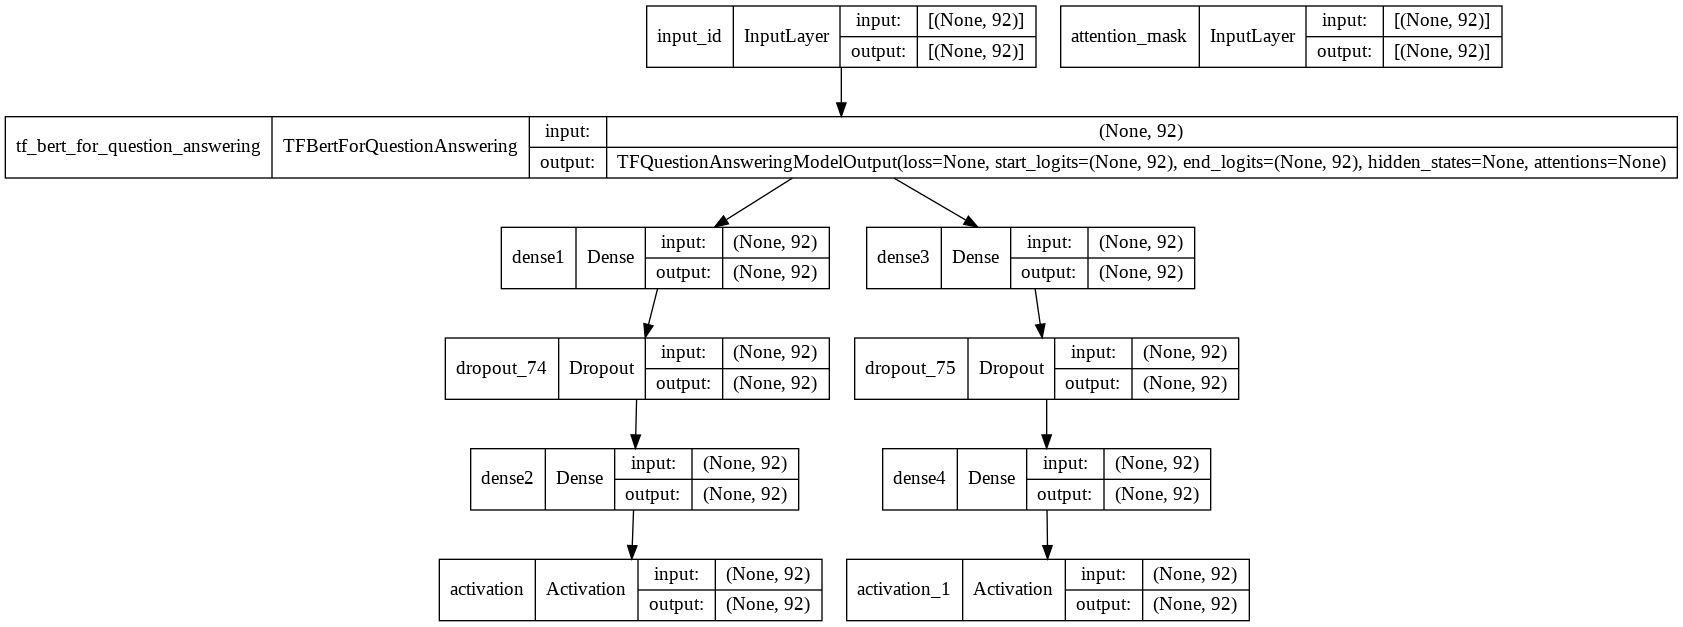

In [64]:
import tensorflow as tf
tf.keras.utils.plot_model(model, 'Model.png',show_shapes=True)

In [65]:
input_data = (input_ids,attention_mask)
output_data = (start_tokens,end_tokens)

val = (input_ids_val,attention_mask_val)
output_val = (start_tokens_val,end_tokens_val)
val_data = (val,output_val)

In [66]:
%load_ext tensorboard
import datetime
import os
#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=2,verbose=3,min_lr = 1e-9)
log_dir= os.path.join("tensorboard_logs1" , datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)
! mkdir  'checkpt1'
file_path = os.path.join('checkpt1/model1.hdf5')
checkpt_save = tf.keras.callbacks.ModelCheckpoint(filepath=file_path,save_weights_only=True,monitor='val_loss',save_best_only=True,verbose=1)
callbacks=[tensorboard_callback,checkpt_save]

In [67]:
opt = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
model.compile(optimizer=opt,loss='categorical_crossentropy')

In [68]:
train_dataset = tf.data.Dataset.from_tensor_slices((input_data, output_data)).shuffle(buffer_size=1024).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices(val_data).batch(32)

In [ ]:
model.fit(train_dataset,epochs=15,validation_data=val_dataset,callbacks=callbacks)

Epoch 1/15
602/602 [==============================] - ETA: 0s - loss: 6.3667 - activation_loss: 2.3084 - activation_1_loss: 4.0216
Epoch 00001: val_loss improved from inf to 4.60828, saving model to checkpt1/model1.hdf5
602/602 [==============================] - 824s 1s/step - loss: 6.3667 - activation_loss: 2.3084 - activation_1_loss: 4.0216 - val_loss: 4.6083 - val_activation_loss: 1.8842 - val_activation_1_loss: 2.6875
Epoch 2/15
602/602 [==============================] - ETA: 0s - loss: 4.7588 - activation_loss: 1.8972 - activation_1_loss: 2.8252
Epoch 00002: val_loss improved from 4.60828 to 4.00920, saving model to checkpt1/model1.hdf5
602/602 [==============================] - 780s 1s/step - loss: 4.7588 - activation_loss: 1.8972 - activation_1_loss: 2.8252 - val_loss: 4.0092 - val_activation_loss: 1.7337 - val_activation_1_loss: 2.2392
Epoch 3/15
602/602 [==============================] - ETA: 0s - loss: 4.2336 - activation_loss: 1.7808 - activation_1_loss: 2.4166
Epoch 00003: 

In [69]:
start_pred_train , end_pred_train = model.predict((input_data))

In [70]:
start_pred_train[0]

array([0.00043309, 0.00043309, 0.00043309, 0.20544244, 0.0047197 ,
       0.06159395, 0.20996657, 0.15312058, 0.23534454, 0.06820514,
       0.00654242, 0.00186022, 0.00322492, 0.00182594, 0.00249408,
       0.00568445, 0.00196824, 0.00110243, 0.00043309, 0.00190159,
       0.00246891, 0.00043309, 0.00043309, 0.00043309, 0.00043309,
       0.00043309, 0.00043309, 0.00043309, 0.00048514, 0.00043309,
       0.00043309, 0.00043309, 0.00043309, 0.00043309, 0.00043309,
       0.00043309, 0.00043309, 0.00043309, 0.00043309, 0.00043309,
       0.00043309, 0.00043309, 0.00043309, 0.00043309, 0.00043309,
       0.00043309, 0.00043309, 0.00043309, 0.00043309, 0.00043309,
       0.00043309, 0.00043309, 0.00043309, 0.00043309, 0.00043309,
       0.00043309, 0.00043309, 0.00043309, 0.00043309, 0.00043309,
       0.00043309, 0.00043309, 0.00043309, 0.00043309, 0.00043309,
       0.00043309, 0.00043309, 0.00043309, 0.00043309, 0.00043309,
       0.00043309, 0.00043309, 0.00043309, 0.00043309, 0.00043

In [71]:
strt =[]
end=[]
pred_values = []
for i in tqdm(range(start_pred_train.shape[0])):
  s = np.argmax(start_pred_train[i,])
  e = np.argmax(end_pred_train[i,])
  text1 = " "+" ".join(x_train_bert['Cleaned_texts'].values[i].split())
  enc = tokenizer.encode(text1)
  st = tokenizer.decode(enc[(s-2):(e-1)])
  pred_values.append(st)
  #s = tf.math.argmax(start_pred_train[i],axis=0).numpy()
  #e = tf.math.argmax(end_pred_train[i],axis=0).numpy()
  #strt.append(s)
  #end.append(e)
len(strt),len(end)

100%|██████████| 19236/19236 [00:13<00:00, 1441.78it/s]


(0, 0)

In [72]:
preds_train = x_train_bert.copy()

In [73]:
preds_train['preds_text'] =  pred_values


In [74]:
preds_train

,textID,Raw_text,Cleaned_texts,sentiment,preds_text
652,a834cef9c6,1st presentation for senior boards? FML,st presentation for senior boards fml,negative,fml
24883,5bfad683d5,yummy curry save me some please lol,yummy curry save me some please lol,positive,yummy
15385,08a8d660b1,I wish I knew someone down there who could hook us up. a friend told me once that they got crappy seats for a show in CHI,i wish i knew someone down there who could hook us up a friend told me once that they got crappy seats for a show in chi,negative,i wish i knew someone down there who could hook us up a friend told me once that they got crappy seats for a show in chi
16753,99a0ff3bef,Lucky u Im stuck in the rain...,lucky u im stuck in the rain,neutral,lucky u im stuck in the rain
19,40e7becabf,Hes just not that into you,hes just not that into you,neutral,hes just not that into you
...,...,...,...,...,...
21628,148582dfe6,THE best job in the world & yes its in Australia http://tinyurl.com/clxl4l,the best job in the world Special yes its in australia URL,positive,best
24747,9ed3b39ceb,Yeah he`s also partial to JT and TI Dead and Gone and Pink`s Sobre,yeah hes also partial to jt and ti dead and gone and pinks sobre,neutral,yeah hes also partial to jt and ti dead and gone and pinks sobre
18164,b2ccc6e924,"Oui, I figured that since its a day off, I`d better start brushing up on my french; so far I have learnt Bonjour and Oui",oui i figured that since its a day off id better start brushing up on my french so far i have learnt bonjour and oui,neutral,oui i figured that since its a day off id better start brushing up on my french so far i have learnt bonjour and oui
10041,5652d8ae75,"if i can get a ticket, but the pickings are lookin slim soo prob not",if i can get a ticket but the pickings are lokin slim so prob not,neutral,if i can get a ticket but the pickings are lokin slim so prob not


In [75]:
#score tập train:
train_preds_text = preds_train.preds_text.str.split().to_list()
train_selected_text = tse_st.Map_Extracted(preprocessed_train_X,train_preds_text)
tse_st.score(train_selected_text,train_y_ex)

0.6640610864326043

In [77]:
# score_df = pd.DataFrame(data ={'selected_text':train_selected_text ,'true_text':train_y_ex, 'sentiment':train_X_df.sentiment})
# check_df = score_df.loc[score_df.sentiment== 'negative',:]
# check_neg = check_df.selected_text.apply(len)
# check_neg = check_neg.loc[check_neg <7].index
# check_df = check_df.loc[check_neg,:]
# tse_st.score(check_df.selected_text.to_list(),check_df.true_text)

In [78]:
#Predict tập val:
start_pred_val , end_pred_val = model.predict((val))

In [79]:
#strt =[]
#end=[]
pred_values_val = []
for i in tqdm(range(start_pred_val.shape[0])):
  s = np.argmax(start_pred_val[i,])
  e = np.argmax(end_pred_val[i,])
  text1 = " "+" ".join(x_val_bert['Cleaned_texts'].values[i].split())
  enc = tokenizer.encode(text1)
  st = tokenizer.decode(enc[(s-2):(e-1)])
  pred_values_val.append(st)
  #s = tf.math.argmax(start_pred_train[i],axis=0).numpy()
  #e = tf.math.argmax(end_pred_train[i],axis=0).numpy()
  #strt.append(s)
  #end.append(e)
#len(strt),len(end)

100%|██████████| 8244/8244 [00:06<00:00, 1351.92it/s]


In [80]:
preds_val = x_val_bert.copy()
preds_val['preds_text'] =  pred_values_val


In [81]:
preds_val

,textID,Raw_text,Cleaned_texts,sentiment,preds_text
3259,f14d0140f1,Yikes! I hope she was okay. I never her heard her say her tummy hurt.,yikes i hope she was okay i never her heard her say her tummy hurt,neutral,yikes i hope she was okay i never her heard her say her tummy hurt
13469,d303e92e0a,aww my son gave me a purple g shock for mother`s day,aw my son gave me a purple g shock for mothers day,positive,aw my son gave me a purple g shock for mothers day
7904,ea50bdcad9,Back from hospital. Doc says I`ll live,back from hospital doc says ill live,positive,back from hospital doc says ill live
14283,22d7ee60ad,boo you can come over and we`ll watch telenovelas and braid each others hair.,boo you can come over and well watch telenovelas and braid each others hair,neutral,boo you can come over and well watch telenovelas and braid each others hair
1282,59e971682c,Lost at bowling again why do i suck,lost at bowling again why do i suck,negative,lost at bowling again why do i suck
...,...,...,...,...,...
12054,126ade42b8,oh that`s cool Thanks!!,oh thats cool thanks,positive,thanks
2137,7f6299624f,"Wish I could listen but because I`m from Canada, the website won`t let me!",wish i could listen but because im from canada the website wont let me,negative,wish i could listen but
1300,1ef247a527,"hahahaha. im listening to my iTunes library, a bit of Sonia Dada atm, ITs good",hahahaha im listening to my itunes library a bit of sonia dada atm its good,positive,hahahaha im listening to my itunes library a bit of sonia dada atm its good
27069,d178e9718d,I dont think so,i dont think so,neutral,i dont think so


In [82]:
#score tập val:
val_preds_text = preds_val.preds_text.str.split().to_list()
val_selected_text = tse_st.Map_Extracted(preprocessed_val_X,val_preds_text)
tse_st.score(val_selected_text,val_y_ex)

0.5969852760465325

In [134]:
# score_df = pd.DataFrame(data ={'selected_text':val_selected_text ,'true_text':val_y_ex, 'sentiment':val_X_df.sentiment})
# check_df = score_df.loc[score_df.sentiment== 'neutral',:]
# check_neg = check_df.selected_text.str.split().apply(len)
# check_neg = check_neg.loc[check_neg==0].index
# #check_df = check_df.loc[check_neg,:]
# tse_st.score(check_df.selected_text.to_list(),check_df.true_text)

In [135]:
# score_df.loc[score_df.sentiment== 'negative',:].selected_text.str.split().apply(len).value_counts()

## 2.3 kết hợp thống kê và deep learning trong rút trích

In [111]:
score_df

,selected_text,true_text,sentiment
3259,Yikes! I hope she was okay. I never her heard her say her tummy hurt.,Yikes! I hope she was okay. I never her heard her say her tummy hurt,neutral
13469,aww my son gave me a purple g shock for mother`s day,aww,positive
7904,Back from hospital. Doc says I`ll live,I`ll live,positive
14283,boo you can come over and we`ll watch telenovelas and braid each others hair.,boo you can come over and we`ll watch telenovelas and braid each others hair.,neutral
1282,Lost at bowling again why do i suck,suck,negative
...,...,...,...
12054,Thanks!!,oh that`s cool Thanks!,positive
2137,Wish I could listen but,"Wish I could listen but because I`m from Canada, the website won`t let me!",negative
1300,"hahahaha. im listening to my iTunes library, a bit of Sonia Dada atm, ITs good",s good,positive
27069,I dont think so,I dont think so,neutral


In [107]:
#score_df.loc[13144,'selected_text'] = []

In [162]:
val_dl_df = pd.DataFrame(data ={'clean_text':cleaned_val_X.Cleaned_texts,'selected_text':val_selected_text ,'true_text':val_y_ex, 'sentiment':val_X_df.sentiment})
val_stat_df =  pd.DataFrame(data ={'clean_text':cleaned_val_X.Cleaned_texts,'selected_text':selected_val_X ,'true_text':val_y_ex, 'sentiment':val_X_df.sentiment})
val_integrate_df = val_dl_df.copy()

In [163]:
# # Lấy neutral bên thống kê qua deep learning:
# neutral_df = val_integrate_df.loc[val_integrate_df.sentiment== 'neutral',:]
# index_neutral =list( neutral_df.index)
# for i in index_neutral:
#    val_integrate_df.loc[i,'selected_text'] = val_stat_df.loc[i,'selected_text']

In [129]:
#fillna with dl
val_integrate_stat = val_stat_df.copy()
null_df = val_integrate_stat.loc[val_integrate_stat.selected_text.str.split().apply(len)==0,:].index
for i in list(null_df):
   val_integrate_stat.loc[i,'selected_text'] = val_dl_df.loc[i,'selected_text']

In [142]:
neg_df = val_integrate_stat.loc[score_df.sentiment== 'negative',:]
# neg_index = neg_df.clean_text.str.split().apply(len)
# neg_smaller_than_7 = neg_index.loc[neg_index <7].index
# for j in list(neg_smaller_than_7):
#    val_integrate_stat.loc[i,'selected_text'] = val_dl_df.loc[i,'selected_text']

In [167]:
# pos_df = val_integrate_stat.loc[score_df.sentiment== 'positive',:]
# check_pos = pos_df.clean_text.str.split().apply(len)
# check_pos = check_pos.loc[check_pos <15].index
# pos_df = pos_df.loc[check_pos,:]
# tse_st.score(pos_df.selected_text.to_list(),pos_df.true_text)

0.4907524611865466

In [177]:
# check_df = val_dl_df.loc[score_df.sentiment== 'positive',:]
# check_neg = check_df.clean_text.str.split().apply(len)
# check_neg = check_neg.loc[check_neg <20].index
# check_df = check_df.loc[check_neg,:]
# tse_st.score(check_df.selected_text.to_list(),check_df.true_text)

0.40471998566214745

In [178]:
# check_df = val_stat_df.loc[score_df.sentiment== 'positive',:]
# check_neg = check_df.clean_text.str.split().apply(len)
# check_neg = check_neg.loc[check_neg <20].index
# check_df = check_df.loc[check_neg,:]
# tse_st.score(check_df.selected_text.to_list(),check_df.true_text)

0.40863805203245257

In [143]:
#state of art
tse_st.score(val_integrate_stat.selected_text.to_list(),val_integrate_stat.true_text)

0.6518411898273556

In [179]:
# pd.set_option('display.max_rows', df.shape[0]+1)
# compare_df = pd.DataFrame(data ={'origin':val_X_df.text,'preprocessed_text':preprocessed_val_X.preprocessed_texts,'selected_text':val_selected_text ,'true_text':val_y_ex, 'sentiment':val_X_df.sentiment})
# index_check = compare_df.loc[compare_df.sentiment == 'negative',['true_text']].true_text.str.split().apply(len)
# index_1 = index_check.loc[index_check == 1].index
# #compare_df.loc[index_1,:]

In [ ]:
tokenizer.encode('st presentation for senior boards fml')

[101, 2358, 8312, 2005, 3026, 7923, 4718, 2140, 102]

In [ ]:
tokenizer.decode([2140])

'##l'

## 2.1 Draft BERT

In [ ]:
train_text = cleaned_train_X.Cleaned_texts.apply((lambda x: "[CLS] " + x + " [SEP]"))
val_text = cleaned_val_X.Cleaned_texts.apply((lambda x: "[CLS] " + x + " [SEP]"))

In [ ]:
def embedding(text, max_seq_len = MAX_SEQ_LEN, last_4_layers = True):
  pass

NameError: ignored

In [ ]:
train_text

652                                                                                         [CLS] st presentation for senior boards fml [SEP]
24883                                                                                         [CLS] yummy curry save me some please lol [SEP]
15385    [CLS] i wish i knew someone down there who could hook us up a friend told me once that they got crappy seats for a show in chi [SEP]
16753                                                                                                [CLS] lucky u im stuck in the rain [SEP]
19                                                                                                     [CLS] hes just not that into you [SEP]
                                                                         ...                                                                 
21628                                                                  [CLS] the best job in the world Special yes its in australia URL [SEP]
24747 

In [ ]:
train_tokenized = train_text.apply((lambda x: tokenizer.tokenize(x)))
indexed_train_tokens = train_tokenized.apply((lambda x:tokenizer.convert_tokens_to_ids(x))) 
val_tokenized = val_text.apply((lambda x: tokenizer.tokenize(x)))
indexed_val_tokens = val_tokenized.apply((lambda x:tokenizer.convert_tokens_to_ids(x))) 

In [ ]:
train_tokenized

652                                                                                                                    [[CLS], st, presentation, for, senior, boards, fm, ##l, [SEP]]
24883                                                                                                               [[CLS], yu, ##mmy, curry, save, me, some, please, lo, ##l, [SEP]]
15385          [[CLS], i, wish, i, knew, someone, down, there, who, could, hook, us, up, a, friend, told, me, once, that, they, got, crap, ##py, seats, for, a, show, in, chi, [SEP]]
16753                                                                                                                              [[CLS], lucky, u, im, stuck, in, the, rain, [SEP]]
19                                                                                                                                [[CLS], he, ##s, just, not, that, into, you, [SEP]]
                                                                                          

In [ ]:
indexed_train_tokens

652                                                                                                                                                [101, 2358, 8312, 2005, 3026, 7923, 4718, 2140, 102]
24883                                                                                                                                [101, 9805, 18879, 15478, 3828, 2033, 2070, 3531, 8840, 2140, 102]
15385               [101, 1045, 4299, 1045, 2354, 2619, 2091, 2045, 2040, 2071, 8103, 2149, 2039, 1037, 2767, 2409, 2033, 2320, 2008, 2027, 2288, 10231, 7685, 4272, 2005, 1037, 2265, 1999, 9610, 102]
16753                                                                                                                                             [101, 5341, 1057, 10047, 5881, 1999, 1996, 4542, 102]
19                                                                                                                                                 [101, 2002, 2015, 2074, 2025, 2008, 2046, 2017, 102]


In [ ]:
tokenizer.decode([101, 2358, 8312, 2005, 3026, 7923, 4718, 2140, 102])

'[CLS] st presentation for senior boards fml [SEP]'

In [ ]:
MAX_SEQ_LEN = 50

def embedding(text, max_seq_len = MAX_SEQ_LEN, last_4_layers = True):
    #Padding
    encoded_input = tokenizer(text, padding='max_length', max_length = MAX_SEQ_LEN, truncation=True, return_tensors='pt')
    encoded_input.to(device)

    # Forward pass 
    model.eval()
    with torch.no_grad():
        model_output = model(**encoded_input, output_hidden_states = True)
        if last_4_layers:
            model_output = model_output[2]
            model_output = torch.stack(model_output[1:]).sum(0)
        else:
            model_output = model_output[0]
    return model_output

In [ ]:
max_len = 0
for i in indexed_train_tokens.values:
    if len(i) > max_len:
        max_len = len(i)

def padding(max_len,tokenized):

    return np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
def attention_mask(padded):
    return np.where(padded != 0, 1, 0)

In [ ]:
train_padded = padding(max_len,indexed_train_tokens)
val_padded = padding(max_len, indexed_val_tokens)

In [ ]:
max_len

45

In [ ]:
train_padded

array([[  101,  2358,  8312, ...,     0,     0,     0],
       [  101,  9805, 18879, ...,     0,     0,     0],
       [  101,  1045,  4299, ...,     0,     0,     0],
       ...,
       [  101, 15068,  2072, ...,     0,     0,     0],
       [  101,  2065,  1045, ...,     0,     0,     0],
       [  101,  4067,  2017, ...,     0,     0,     0]])

In [ ]:
train_attention_mask = np.where(train_padded != 0, 1, 0)

In [ ]:
train_attention_mask

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [ ]:
train_tokens_tensor = torch.tensor(train_padded)
#train_attention_mask = torch.tensor(train_attention_mask)

In [ ]:
train_attention_mask = torch.tensor(train_attention_mask)

In [ ]:
model.eval()
with torch.no_grad():
    outputs = model(train_tokens_tensor, attention_mask=train_attention_mask)

In [ ]:
# Define a new example sentence with multiple meanings of the word "bank"
text = "After excited money from the bank vault, the bank robber was seen fishing on the Mississippi river bank."
#texts = ["After stealing money from the bank vault, the bank robber was seen fishing on the Mississippi river bank.", "I love the mouse that is moving around me",\
#         "I buy a mouse that is compatible with my computer."]
# Add the special tokens.
marked_text = "[CLS] " + text + " [SEP]"
#marked_texts = ["[CLS] " + text + " [SEP]" for text in texts]
# Split the sentence into tokens.
tokenized_text = tokenizer.tokenize(marked_text)

# Map the token strings to their vocabulary indeces.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# Display the words with their indeces.
for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))

input_ids       100
token_type_ids    100
attention_mask    100


In [ ]:
indexed_tokens

[101,
 2044,
 7568,
 2769,
 2013,
 1996,
 2924,
 11632,
 1010,
 1996,
 2924,
 27307,
 2001,
 2464,
 5645,
 2006,
 1996,
 5900,
 2314,
 2924,
 1012,
 102]

In [ ]:
tokens_tensor = torch.tensor([indexed_tokens])

In [ ]:
model.eval()

In [ ]:
with torch.no_grad():

    outputs = model(tokens_tensor)

In [ ]:
outputs #[# layers, # batches, # tokens, # features]

In [ ]:
hidden_states = outputs[2]

In [ ]:
print ("Number of layers:", len(hidden_states), "  (initial embeddings + 12 BERT layers)")
layer_i = 0

print ("Number of batches:", len(hidden_states[layer_i]))
batch_i = 0

print ("Number of tokens:", len(hidden_states[layer_i][batch_i]))
token_i = 0

print ("Number of hidden units:", len(hidden_states[layer_i][batch_i][token_i]))

Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 22
Number of hidden units: 768


In [ ]:
hidden_states[layer_i][0]

tensor([[ 0.1686, -0.2858, -0.3261,  ..., -0.0276,  0.0383,  0.1640],
        [ 0.2329,  0.1390,  0.2979,  ..., -0.0655,  0.8885,  0.5109],
        [ 0.2257, -0.7165, -0.7255,  ...,  0.4844,  0.6030, -0.0957],
        ...,
        [-0.0374, -0.6155, -1.4419,  ...,  0.0793, -0.0811, -0.3802],
        [-0.0228,  0.4207, -0.3288,  ...,  0.4464,  0.5178,  0.5501],
        [-0.2350,  0.1566, -0.0462,  ..., -0.4206,  0.3074, -0.2288]])

In [ ]:
#Desired dimensions:

#[# tokens, # layers, # features]
# `hidden_states` is a Python list.
print('      Type of hidden_states: ', type(hidden_states))

# Each layer in the list is a torch tensor.
print('Tensor shape for each layer: ', hidden_states[0].size())

      Type of hidden_states:  <class 'tuple'>
Tensor shape for each layer:  torch.Size([1, 22, 768])


In [ ]:
token_embeddings = torch.stack(hidden_states, dim=0)

token_embeddings.size()

torch.Size([13, 1, 22, 768])

In [ ]:
# Remove dimension 1, the "batches".
token_embeddings = torch.squeeze(token_embeddings, dim=1)

token_embeddings.size()

torch.Size([13, 22, 768])

In [ ]:
# Swap dimensions 0 and 1.
token_embeddings = token_embeddings.permute(1,0,2)
token_embeddings.size()

torch.Size([22, 13, 768])

In [ ]:
#lấy luôn 4 tầng cuối
# Stores the token vectors, with shape [22 x 3,072]
token_vecs_cat = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:
    
    # `token` is a [12 x 768] tensor

    # Concatenate the vectors (that is, append them together) from the last 
    # four layers.
    # Each layer vector is 768 values, so `cat_vec` is length 3,072.
    cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)
    
    # Use `cat_vec` to represent `token`.
    token_vecs_cat.append(cat_vec)

print ('Shape is: %d x %d' % (len(token_vecs_cat), len(token_vecs_cat[0])))


Shape is: 22 x 3072


In [ ]:
#Sum 4 tầng cuối
# Stores the token vectors, with shape [22 x 768]
token_vecs_sum = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:

    # `token` is a [12 x 768] tensor

    # Sum the vectors from the last four layers.
    sum_vec = torch.sum(token[-4:], dim=0)
    
    # Use `sum_vec` to represent `token`.
    token_vecs_sum.append(sum_vec)

print ('Shape is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))

Shape is: 22 x 768


In [ ]:
for i, token_str in enumerate(tokenized_text):
  print (i, token_str)

0 [CLS]
1 after
2 stealing
3 money
4 from
5 the
6 bank
7 vault
8 ,
9 the
10 bank
11 robber
12 was
13 seen
14 fishing
15 on
16 the
17 mississippi
18 river
19 bank
20 .
21 [SEP]


In [ ]:
print('First 5 vector values for each instance of "bank".')
print('')
print("bank vault   ", str(token_vecs_sum[6][:5]))
print("bank robber  ", str(token_vecs_sum[10][:5]))
print("river bank   ", str(token_vecs_sum[19][:5]))

First 5 vector values for each instance of "bank".

bank vault    tensor([ 3.3596, -2.9805, -1.5421,  0.7065,  2.0031])
bank robber   tensor([ 2.7359, -2.5577, -1.3094,  0.6797,  1.6633])
river bank    tensor([ 1.5266, -0.8895, -0.5152, -0.9298,  2.8334])


## 2.2 LSTM

In [ ]:
#### Tiền xử lý cho deep learning
#0. Sử dụng lại clean text ở mô hình thống kê trên
#1. Tạo dictionary word2 index
#2. Chuyển câu về vector vs các con số đại diện cho từ (từ bước 1), padding cho các câu bằng nhau

vocab_size = len(tse_st.vocabs)
embedding_dim = 3
max_length = 35
trunc_type='post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(cleaned_train_X.Cleaned_texts.to_list())
word_index = tokenizer.word_index
train_sequences = tokenizer.texts_to_sequences(cleaned_train_X.Cleaned_texts.to_list())
train_padded = pad_sequences(train_sequences,maxlen=max_length,padding='post',truncating=trunc_type)

val_sequences = tokenizer.texts_to_sequences(cleaned_val_X.Cleaned_texts.to_list())
val_padded = pad_sequences(val_sequences,maxlen=max_length,padding='post',truncating=trunc_type)

In [ ]:
train_padded

array([[ 568, 1678,   14, ...,    0,    0,    0],
       [ 853, 3450,  767, ...,    0,    0,    0],
       [   2,  112,    2, ...,    0,    0,    0],
       ...,
       [7919,    2, 1456, ...,    0,    0,    0],
       [  73,    2,   72, ...,    0,    0,    0],
       [ 172,   10,  132, ...,    0,    0,    0]], dtype=int32)

In [ ]:
len(tse_st.likelihood)

16770

In [ ]:
#word_index
#len(tse_st.likelihood)

In [ ]:
# tse_st.likelihood['crush']

[7.078299261644908e-05, 0.0002255990460383196, 0.00012950907426913713]

In [ ]:
# word embeddings with score representation
def word2vec_statistic(word_index,likelihood):
  embeds = np.zeros(shape = (vocab_size,3),dtype = 'float32')
  embeds[0] = np.zeros(3,dtype = 'float32')
  count_in = 0
  count_out = 0
  for word in list(word_index.keys())[0:vocab_size-1]:
    i = word_index[word]
    if word in likelihood:
      embeds[i]= likelihood[word]
      count_in += 1
    else:
      embeds[i] = np.random.uniform(-0.25,0.25,3)
      count_out += 1
  print(count_in,count_out)
  return embeds


In [ ]:
embs = word2vec_statistic(word_index,tse_st.likelihood)

12340 4429


In [ ]:
embs

array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 4.1426221e-05,  1.6219188e+02,  4.0486815e-05],
       [ 1.1813217e+01,  4.5117878e+01,  8.1252337e+00],
       ...,
       [ 2.1684538e-01, -5.0188310e-02, -1.3487662e-01],
       [-2.1302557e-01,  9.6522927e-02,  2.1913543e-01],
       [-2.3172331e-01, -1.6626121e-01,  9.0431198e-02]], dtype=float32)

In [ ]:
word_index['crush']

1352

In [ ]:
embs.shape

(15235, 3)

In [ ]:
#Xử lý nhãn:
def convert_labels_to_matrix(input_padded,preprocessed_y_ex):
    train_labl = [' '.join(list(words.values())) for words in preprocessed_y_ex.preprocessed_texts]
    train_labl_sequences = tokenizer.texts_to_sequences(train_labl)
    label_matrix = []
    for sentence,lable in zip(input_padded, train_labl_sequences):
      label_temp = np.zeros(38)
      for i,w in enumerate(sentence):
            for s in lable:
                if s==w:
                    label_temp[i] = 1
      label_matrix.append(label_temp)
    return np.array(label_matrix)

def convert_label_matrix_to_ind(input_padded,output_matrix):
    extracted_inds = []
    for tweet,extracted in zip( input_padded, output_matrix):
          words = []
          for i,w in enumerate(extracted):
              if w==1:
                  try:
                    words.append(tweet[i])
                  except:
                    continue
          extracted_inds.append(words)
    return extracted_inds

        




I am happy -> [0,0,1]
I am not happy -> [0,0,1,1]

In [ ]:
label_train = convert_labels_to_matrix(train_padded,preprocessed_train_y_ex)
label_val = convert_labels_to_matrix(val_padded,preprocessed_val_y_ex)
#convert_label_matrix_to_ind(padded,label_train_one_hot)

In [ ]:
from tensorflow.keras.utils import to_categorical
train_sentiment = to_categorical(preprocessed_train_X.sentiment,num_classes=3)
val_sentiment = to_categorical(preprocessed_val_X.sentiment,num_classes=3)

In [ ]:
input_train_sentiment = np.array(preprocessed_train_X.sentiment).reshape(-1,1)
input_val_sentiment = np.array(preprocessed_val_X.sentiment).reshape(-1,1)

In [ ]:
input_train_sentiment.shape

(19236, 1)

In [ ]:
# input_layer = Input(shape=(300,))
# emb_layer = Embedding(5000,100)(input_layer)

# lstm_layer1 = Bidirectional(LSTM(50, activation="sigmoid", return_sequences=False))(emb_layer)

# hidden_dense_layer = Dense(50,activation="sigmoid")(lstm_layer1)
# dense_layer = Dense(1,activation="sigmoid")(hidden_dense_layer)

# model = Model(inputs=input_layer, outputs=dense_layer)


In [ ]:
def my_loss(true,pred):
  #print(true.shape,pred.shape)
  loss_obj = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.SUM)
  loss = loss_obj (true,pred)
  return loss/128 #batch size

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 35, 3)        45705       ['input_5[0][0]']                
                                                                                                  
 embedding_5 (Embedding)        (None, 3, 3)         9           ['input_6[0][0]']                
                                                                                            

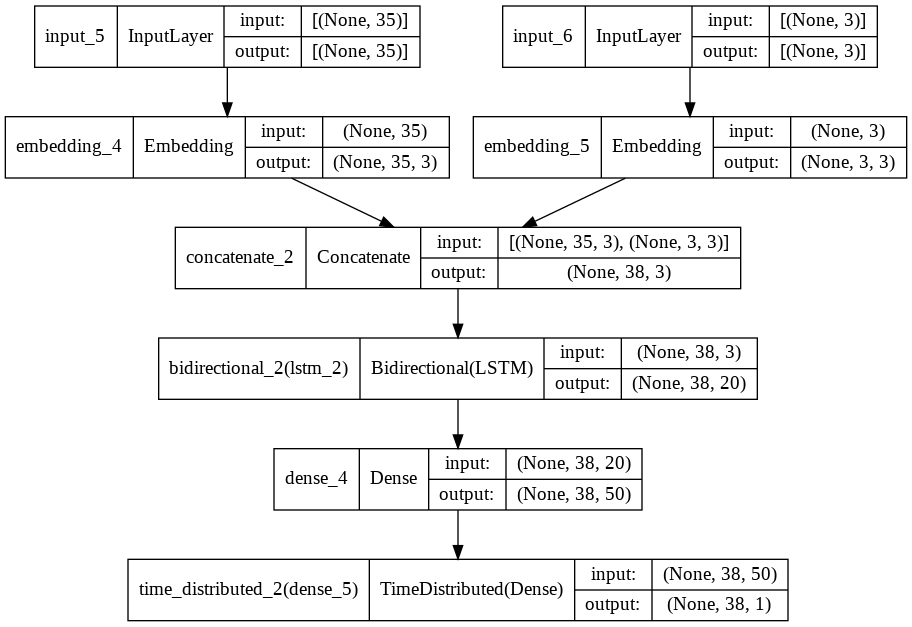

In [ ]:
input_text_layer = Input(shape = (35,))
emb_layer_text = Embedding(vocab_size,3,input_length=max_length,weights=[embs])(input_text_layer)
#pool_text_layer = GlobalAveragePooling1D()(emb_layer_text)

input_sentiment_layer = Input(shape =(3,))
emb_layer_sentiment= Embedding(3,3,input_length=3)(input_sentiment_layer)
#flat_layer = Flatten()(input_sentiment_layer)

concat_layer= Concatenate(axis = 1)([emb_layer_text,emb_layer_sentiment])
lstm_layer1 = Bidirectional(LSTM(10, activation="sigmoid", return_sequences=True))(concat_layer)

hidden_dense_layer = Dense(50,activation="sigmoid")(lstm_layer1)
dense_layer = TimeDistributed(Dense(1,activation='sigmoid'))(hidden_dense_layer)

model = Model(inputs=[input_text_layer,input_sentiment_layer], outputs=dense_layer)

model.compile(loss= my_loss, optimizer="adam",metrics=["accuracy"])
print (model.summary())
mc = ModelCheckpoint("best_checkpoint.h5", monitor="val_accuracy" , save_best_only=True, save_weights_only=True)
#mc = ModelCheckpoint("best_checkpoint.h5", monitor="val_accuracy" , save_best_only=True, save_weights_only=True)
tf.keras.utils.plot_model(model, show_shapes=True)
#model.fit(X_train,y_train,validation_data=(X_val,y_val), epochs= 20, batch_size=50, callbacks=[mc])

In [ ]:
tf.config.experimental_run_functions_eagerly(True)
tf.config.run_functions_eagerly(True)

In [ ]:
label_train.shape

(19236, 36)

In [ ]:
model.fit([train_padded,train_sentiment],label_train,validation_data=([val_padded,val_sentiment],label_val), epochs= 20, batch_size=128,callbacks=[mc])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
151/151 [==============================] - 39s 255ms/step - loss: 0.5031 - accuracy: 0.7721 - val_loss: 0.4398 - val_accuracy: 0.8087
Epoch 2/20
151/151 [==============================] - 38s 251ms/step - loss: 0.3854 - accuracy: 0.8130 - val_loss: 0.3233 - val_accuracy: 0.8169
Epoch 3/20
151/151 [==============================] - 38s 254ms/step - loss: 0.2920 - accuracy: 0.8231 - val_loss: 0.2732 - val_accuracy: 0.8259
Epoch 4/20
151/151 [==============================] - 34s 224ms/step - loss: 0.2649 - accuracy: 0.8298 - val_loss: 0.2601 - val_accuracy: 0.8307
Epoch 5/20
151/151 [==============================] - 38s 253ms/step - loss: 0.2547 - accuracy: 0.8339 - val_loss: 0.2534 - val_accuracy: 0.8348
Epoch 6/20
151/151 [==============================] - 35s 229ms/step - loss: 0.2486 - accuracy: 0.8382 - val_loss: 0.2489 - val_accuracy: 0.8360
Epoch 7/20
151/151 [==============================] - 34s 227ms/step - loss: 0.2444 - accuracy: 0.8417 - val_loss: 0.2459 - val_ac

In [ ]:
train_pred = model.predict([train_padded,train_sentiment])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [ ]:
train_pred[0]

array([[5.9153116e-01],
       [5.1225692e-01],
       [4.7129771e-01],
       [4.4762367e-01],
       [4.9879482e-01],
       [7.0727968e-01],
       [7.0333481e-04],
       [4.5052171e-04],
       [4.1231513e-04],
       [3.9839745e-04],
       [3.9264560e-04],
       [3.8987398e-04],
       [3.8823485e-04],
       [3.8704276e-04],
       [3.8588047e-04],
       [3.8471818e-04],
       [3.8337708e-04],
       [3.8200617e-04],
       [3.8033724e-04],
       [3.7851930e-04],
       [3.7646294e-04],
       [3.7431717e-04],
       [3.7175417e-04],
       [3.6895275e-04],
       [3.6588311e-04],
       [3.6239624e-04],
       [3.5864115e-04],
       [3.5431981e-04],
       [3.4984946e-04],
       [3.4499168e-04],
       [3.4010410e-04],
       [3.3509731e-04],
       [3.2919645e-04],
       [3.2293797e-04],
       [3.2731891e-04],
       [3.6635995e-04],
       [3.6680698e-04],
       [4.1875243e-04]], dtype=float32)

In [ ]:
def ind2word(preds):
  index2word = {i:w for w,i in word_index.items()}
  selected_text = []
  for s in preds:
    words = []
    for j in s:
      try:
        word = index2word[j]
        words.append(word)
      except:
        continue
    selected_text.append(words)
  return selected_text 

In [ ]:
train_pred1 = np.squeeze(train_pred)
train_pred1 = np.where(train_pred1>0.5,1,0)
train_preds_ind =convert_label_matrix_to_ind(train_padded,train_pred1)
train_extracted_text = ind2word(train_preds_ind)
train_selected_text = tse_st.Map_Extracted(preprocessed_train_X,train_extracted_text)
tse_st.score(train_selected_text,train_y_ex)

0.548866488125039

In [ ]:
val_pred = model.predict([val_padded,val_sentiment])


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [ ]:
val_pred1 = np.squeeze(val_pred)
val_pred2 = np.where(val_pred1>0.5,1,0)
val_preds_ind =convert_label_matrix_to_ind(val_padded,val_pred2)
val_extracted_text = ind2word(val_preds_ind)
val_selected_text = tse_st.Map_Extracted(preprocessed_val_X,val_extracted_text)
tse_st.score(val_selected_text,val_y_ex)

0.4890995196480521

In [ ]:
train_preds_ind[0:5]

[[549, 624, 14, 1248, 1192, 1249],
 [690, 77, 190, 54],
 [2,
  102,
  2,
  601,
  262,
  179,
  62,
  175,
  151,
  2379,
  213,
  43,
  5,
  142,
  519,
  20,
  500,
  16,
  95,
  50,
  1981,
  1139,
  14,
  5,
  163,
  13],
 [480, 63, 17, 459, 13, 4, 205],
 [94, 26, 32, 16, 252, 11]]

In [ ]:
train_extracted_text = ind2word(train_preds_ind)
train_extracted_text[0:5]

[['st', 'present', 'for', 'senior', 'board', 'fml'],
 ['yummi', 'some', 'pleas', 'lol'],
 ['i',
  'wish',
  'i',
  'knew',
  'someon',
  'down',
  'there',
  'who',
  'could',
  'hook',
  'us',
  'up',
  'a',
  'friend',
  'told',
  'me',
  'onc',
  'that',
  'they',
  'got',
  'crappi',
  'seat',
  'for',
  'a',
  'show',
  'in'],
 ['lucki', 'u', 'im', 'stuck', 'in', 'the', 'rain'],
 ['he', 'just', 'not', 'that', 'into', 'you']]

In [ ]:
#val_padded = pad_sequences(val_sequences,maxlen=max_length,padding='post',truncating=trunc_type)

In [ ]:
pd.set_option('display.max_rows', df.shape[0]+1)
compare_df = pd.DataFrame(data ={'origin':train_X_df.text,'selected_text':train_selected_text ,'true_text':train_y_ex, 'sentiment':train_X_df.sentiment})
compare_df
#compare_df.loc[compare_df.sentiment == 'positive',:]

In [ ]:
label_train[0]

NameError: ignored

In [ ]:
val_selected_text[0:10]

['I hope she was okay. I never her heard her say her tummy hurt.',
 'aww my son gave me a purple g shock for mother`s day',
 'Back from hospital. Doc says I`ll live',
 'boo you can come over and we`ll watch and braid each others hair.',
 'Lost at bowling again why do i suck',
 'Bonjour Twitterland',
 'i guess ill never have it but the sad thing is that u didn`t put an Alternate e-mail!! cause if u dont remember ur secret',
 'watching matilda with a bowl of noodles',
 'Thanks Amy! That video is so awesome! Did you see He`s amazing in that too!!',
 'im sad about missing out on the opportunity to be in new video.']

## 3. Rút trích text trên tập test:

In [ ]:
test_df = pd.read_csv('Applied-Data-Science-Group-7/test.csv')
test_df

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -- skyscrapers galore). Good tweeps in China: (SH) (BJ).,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to quit her company, such a shame!",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive
...,...,...,...
3529,e5f0e6ef4b,"its at 3 am, im very tired but i can`t sleep but i try it",negative
3530,416863ce47,"All alone in this old house again. Thanks for the net which keeps me alive and kicking! Whoever invented the net, i wanna kiss your hair!",positive
3531,6332da480c,I know what you mean. My little dog is sinking into depression... he wants to move someplace tropical,negative
3532,df1baec676,_sutra what is your next youtube video gonna be about? I love your videos!,positive


In [ ]:
test_preprocessed,cleaned_test_df = preprocess_tweets(test_df)

In [ ]:
preds_extracted_text = model_full.extract(test_preprocessed)
preds_extracted_text[0:5]

['Last session of the day http://twitpic.com/67ezh',
 'exciting Good',
 'Recession shame!',
 'happy',
 '']

## 4. Submission

In [ ]:
submission_df = pd.DataFrame(data = {'textID': test_df.textID,'selected_text':pd.Series(preds_extracted_text)})

In [ ]:
submission_df.to_csv("submission.csv", index=False)

In [ ]:
submission_df.head(5)

,textID,selected_text
0,f87dea47db,Last session of the day http://twitpic.com/67ezh
1,96d74cb729,exciting Good
2,eee518ae67,Recession shame!
3,01082688c6,happy
4,33987a8ee5,


In [ ]:
# y_test = test_df.sentiment.map({'positive':1,'neutral':0,'negative':-1}).to_list()
# tweets_test = test_df.text.to_list()

In [ ]:
#Extract_text(y_test,preprocessing(tweets_test),likelihood)

In [ ]:
# submission = pd.DataFrame(data ={'textID': test_df.textID,'selected_text':pd.Series(extracted_text)})
# predict